# Experiments in neural multivariate population codes - Noise correlations
Code adapted from S. Keemink & M. van Rossum ([paper](http://biorxiv.org/content/biorxiv/early/2017/03/04/113803.full.pdf))

In [1]:
import numpy as np
from   numpy import exp,cos,sin,pi,tan,sqrt,angle,absolute,eye,dot
import matplotlib.pyplot as plt
import seaborn # makes figures prettier (otherwise unused)
from DeDist import dedist
from __future__ import division
import dill
# removes need for plt.show() after every new plot
%matplotlib inline

In [2]:
# Set default figure size
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
# Restore session state i.e. all objects
dill.load_session('session_state.pkl')

# Save current session state
# Unix compress file: $ gzip session_state.pkl
# dill.dump_session('session_state.pkl')

### Setting up population coding model

We are using a homogeneous model with broad, bell-shaped tuning curves uniformly distributed over the stimulus space.

We have a population of $N$ neurons with identical tuning curves:
$$g_i(s)=A\exp\Bigg[-\frac{(s-\phi_i)^2}{2\omega^2}\Bigg]$$

where the symbols correspond to:
* $A$ - Amplitude (maximum firing rate; baseline firing rate assumed to be zero)
* $s$ - Stimulus (orientation; one-dimensional quantity)
* $\phi_i$ - Preferred stimulus for neuron $i$ in range $[-\pi, \pi]$
* $\omega$ - Width of tuning curve

Dense coding assumption; we require $\frac{2\pi}{N} \ll \omega$ 

Note: Currently, we are modelling orientation selectivity using a Gaussian (non-circular) tuning curve. Plan to add experiments using a von Mises (circular Gaussian) tuning curve later.

In [134]:
# Tuning curve parameters
N_NEURONS = 100
AMPLITUDE = 1.0
TUNING_WIDTH = 0.5

# Array of orientations corresponding to neurons' preferred stimuli
PREF_STIMS = np.linspace(-pi, pi, N_NEURONS+1)[:-1]

def tuning_curve(pref_stim, stimulus):
    return AMPLITUDE * exp( - (stimulus - pref_stim)**2 / (2 * TUNING_WIDTH**2) )

### Modelling response to multivariate stimuli

We consider a 2-dimensional stimulus $\mathbf{s} = (s_1, s_2)$ and model the average response of a neuron using the linear coding model ([Treue et al. 2000](http://www.nature.com/neuro/journal/v3/n3/abs/nn0300_270.html)):
$$f_i(\mathbf{s})=g_i(s_1)+g_i(s_2)$$

Next, we redefine the system in terms of the sum ($\eta$) and difference ($\Theta$) of the angles in the 2-dimensional stimulus.

We concentrate on the difference or opening angle, defined as $\Theta = s_2 - s_1$, such that the tuning of neuron $i$ becomes:
$$f_i(\Theta)=g_i(\Theta/2)+g_i(-\Theta/2)$$

In [135]:
def tuning_curve_2d(pref_stim, stim_1, stim_2):
    return tuning_curve(pref_stim, stim_1) + tuning_curve(pref_stim, stim_2)

def tuning_curve_theta(pref_stim, opening_angle):
    return tuning_curve_2d(pref_stim, opening_angle/2, -opening_angle/2)

## Simulating trial-to-trial variability

We model the stochasticity in trial-to-trial neuron responses by adding a Gaussian noise term to the (average) population response given by the neurons' tuning curves.

The population response (N-dimensional vector) to a stimulus $\Theta$ is given by: $\mathbf{r} = \mathbf{f}(\Theta) + \mathbf{v}$

where:
* $\mathbf{f}(\Theta)$ - average population response; $(f_1(\Theta), ..., f_N(\Theta))^T$
* $\mathbf{v}$ - Gaussian noise term $\mathbf{v} \sim \mathcal{N}(\mathbf{0}, Q)$ where 
    * $Q$ - covariance matrix which models correlations in the trial-to-trial variability of neuron responses (*noise correlations*)

### Limited range correlation noise model

We begin with the limited range correlation model in which neurons with similar stimulus preferences have greater noise correlations.

Firstly, we generate the matrix (NxN) of functional distances representing the pairwise (circular) distances between preferred stimuli.

The distances are computed using the expression: $\phi_j - \phi_k = \arg \exp[i(\phi_j - \phi_k)]$

In [11]:
# Standard deviation of noise
NOISE_SIGMA = 0.2 # TODO: Do we want to keep this constant?

In [13]:
PREF_ANG_DISTS = PREF_STIMS - PREF_STIMS[:,None] # (N,N)
# PREF_ANG_DISTS = absolute(angle(exp(1j * PREF_ANG_DISTS))) # in range [0,pi]
PREF_ANG_DISTS = absolute(PREF_ANG_DISTS) # non-circular correlation matrix

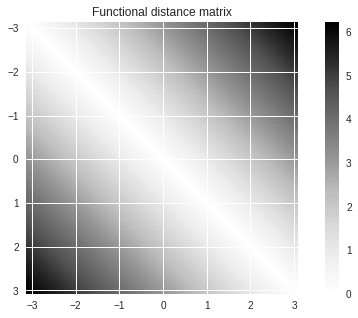

In [14]:
data_coords = [PREF_STIMS[0], PREF_STIMS[-1], PREF_STIMS[-1], PREF_STIMS[0]]
plt.imshow(PREF_ANG_DISTS, cmap='Greys', extent=data_coords)
plt.colorbar()
plt.title('Functional distance matrix')

Then we construct the correlation matrix, $R$, using the functional distances.

The matrix has the form: $r_{jk} = c(|\phi_j - \phi_k|) + \delta_{jk}(1 - c(0))$ 
where 
$$c(|\phi_j - \phi_k|) = c_0 \exp\bigg(-\frac{|\phi_j - \phi_k|}{L}\bigg)$$

We introduce two correlation parameters:
* $c_0$ - Max correlation
* $L$ - Correlation length

The covariance matrix, $Q$, is constructed as follows: $Q = SRS$

where $S = \sigma I_N$ i.e. uniform variance across neurons

In [12]:
def construct_corr_matrix(max_corr, corr_length):
    return max_corr * (exp(-PREF_ANG_DISTS / corr_length) - eye(N_NEURONS)) + eye(N_NEURONS)

def construct_cov_matrix(max_corr=1.0, corr_length=0.5):
    corr_mtx = construct_corr_matrix(max_corr, corr_length)
    stds_mtx = NOISE_SIGMA * eye(N_NEURONS) # matrix of standard deviations
    return dot(stds_mtx, dot(corr_mtx, stds_mtx))

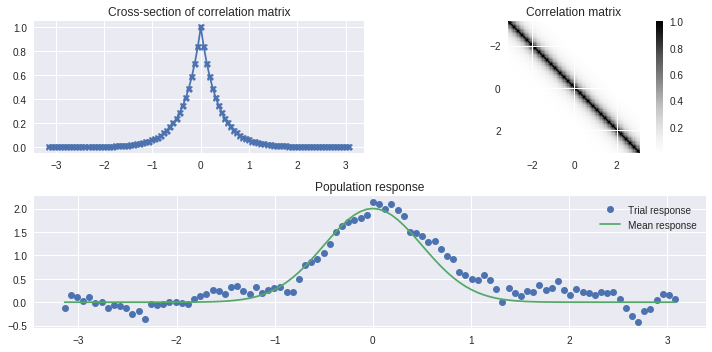

In [65]:
# Visualisation of correlation matrix
max_corr = 1.0
corr_length = 0.35

# Cross-section of correlation matrix
plt.subplot(221) 
corr_mtx = construct_corr_matrix(max_corr, corr_length)
plt.plot(PREF_STIMS, corr_mtx[50], '-X')
plt.title('Cross-section of correlation matrix')

# Correlation matrix
plt.subplot(222) 
data_coords = [PREF_STIMS[0], PREF_STIMS[-1], PREF_STIMS[-1], PREF_STIMS[0]]
plt.imshow(corr_mtx, cmap='Greys', extent=data_coords)
plt.colorbar()
plt.title('Correlation matrix')

# Population response
plt.subplot(212)
# sample population response
stim = 0.0
mean_pop_res = tuning_curve_theta(PREF_STIMS, stim)
cov_mtx = construct_cov_matrix(max_corr, corr_length)
pop_res = np.random.multivariate_normal(mean_pop_res, cov_mtx)
plt.plot(PREF_STIMS, pop_res, 'o', label='Trial response')
plt.plot(PREF_STIMS, mean_pop_res, label='Mean response')
plt.legend()
plt.title('Population response')

plt.tight_layout()

## Maximum Likelihood decoding

After specifying the correlation parameters $(c_0, L)$, we construct a covariance matrix.

We can then generate (noisy) population responses by sampling from the multivariate Gaussian distribution $\mathbf{r} \sim \mathcal{N}(\mathbf{f}(\Theta), Q)$

The distribution has the probability density function:
$$p(\mathbf{r} | \Theta) = \frac{1}{\sqrt{(2\pi)^N \det{Q}}} \exp{\Big\{-\frac{1}{2}[\mathbf{r} - \mathbf{f}(\Theta)]^T Q^{-1} [\mathbf{r} - \mathbf{f}(\Theta)]\Big\}}$$

For some noisy population response $\mathbf{r}$, we can compute an estimate $\hat{\theta}$ using the maximum likelihood decoder.

i.e. we choose the candidate stimulus $\theta$ which maximises the probability that the stimulus generated the response (*likelihood*)

$$\hat{\theta} = \arg \max_{\theta}{\log{p(\mathbf{r} | \theta)}}$$

We can ignore terms independent of $\theta$ as they do not contribute to the ML estimate. Hence, we have the form:

$$\hat{\theta} = \arg \min_{\theta}{\Big\{ [\mathbf{r} - \mathbf{f}(\theta)]^T Q^{-1} [\mathbf{r} - \mathbf{f}(\theta)]\Big\}}$$

To determine the ML estimate, we use a *brute-force* approach in which the likelihood function (or more accurately the simplified *error* function) is evaluated at every point in a fine-spaced grid of parameter values (i.e. candidate stimuli).

The candidate stimulus which gives rise to the minimum error is the estimate.

In [26]:
# Candidate estimates to evaluate error function
N_CAND_ESTS = 100
CAND_ESTS = np.linspace(0, pi, N_CAND_ESTS+1)[:-1]

# Stimuli (opening angles) for which bias and variance are to be calculated
N_THETAS = 100
THETAS = np.linspace(0, pi/2, N_THETAS)

In [13]:
# TODO: Seed random number generator to get repeatable results

# Simulates noisy responses then proceeds to decoding them
def get_ML_ests(cov_mtx, n_realisations=5000):
    # realisation = simulated population response
    
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)
    estimate_dists = np.zeros((N_THETAS, n_realisations))
    
    # Simulate neuron responses followed by decoding for each stimulus in THETAS
    for stim_idx in range(N_THETAS):
        stim = THETAS[stim_idx]
                
        # Generate noisy pop. responses by sampling multivariate distribution
        avg_pop_res = tuning_curve_theta(PREF_STIMS, stim)
        pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)
                
        # For each noisy response, compute error wrt candidate stimuli
        avg_tuning_curves = tuning_curve_theta(PREF_STIMS, CAND_ESTS[:,None])
        tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.inv(cov_mtx), axes=1 )
        errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))
        
        # Find minimum error stimuli for each realisation
        estimate_dists[stim_idx,:] = CAND_ESTS[errors.argmin(axis=0)]
        
        # Compute bias and variance
        mean_est = estimate_dists[stim_idx,:].mean()
        biases[stim_idx] = mean_est - stim
        variances[stim_idx] = ((estimate_dists[stim_idx,:] - mean_est)**2).mean()

    return [estimate_dists, biases, variances]

In [52]:
cov_mtx = construct_cov_matrix(max_corr=1.0, corr_length=0.1)

n_realisations = 20

stim = THETAS[-1]

estimate_dist = np.zeros(n_realisations)

# Generate noisy pop. responses by sampling multivariate distribution
avg_pop_res = tuning_curve_theta(PREF_STIMS, stim)
pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)

# For each noisy response, compute error wrt candidate stimuli
avg_tuning_curves = tuning_curve_theta(PREF_STIMS, CAND_ESTS[:,None])

inv_mtx = np.linalg.inv(cov_mtx)

# tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.inv(cov_mtx), axes=1 )
# errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))

# # Find minimum error stimuli for each realisati
# estimate_dist[:] = CAND_ESTS[errors.argmin(axis=0)]

# # Compute bias and variance
# mean_est = estimate_dist.mean()
# bias = mean_est - stim
# variance = ((estimate_dist - mean_est)**2).mean()

In [53]:
inv_mtx[49]

array([ -4.23407023e-13,  -1.12814214e-26,  -5.57046427e-28,
         6.65481053e-27,  -9.79682639e-26,   2.77897365e-25,
        -2.27090523e-25,   5.61182457e-26,  -1.76272451e-26,
        -1.87088939e-24,   5.56662972e-24,  -3.96747399e-24,
         3.48237771e-25,  -2.46301046e-23,   1.62422868e-23,
         1.08303800e-22,  -1.02338846e-22,   1.33308704e-23,
         1.28582912e-22,  -1.49038966e-21,   3.66262569e-21,
        -2.68654764e-21,  -3.31905701e-21,   4.22749539e-21,
         1.26902737e-20,  -1.30879074e-20,  -5.21697982e-20,
         1.50364325e-19,  -3.07060092e-19,   5.08292815e-19,
         1.40547466e-19,  -2.02177918e-18,   3.52149917e-18,
        -6.09748628e-18,   2.74749543e-18,   1.76087532e-17,
        -3.02297332e-17,   1.86666122e-17,  -2.19789681e-17,
         6.44278653e-17,  -1.44589454e-16,   2.46094077e-16,
        -4.47902607e-16,   9.23960359e-16,  -9.01935121e-16,
         1.16875844e-15,  -4.74414893e-15,   4.34355393e-15,
        -1.86432488e+01,

## Simulations
#### Simulation 1: vary max correlation

* Max correlation: $c_0 \in [0,1]$ with steps of 0.1
* Correlation length: $L = 0.5$

Note that $c_0 = 0$ is equivalent to independent neurons (uncorrelated).

In [14]:
# Generates string label representing correlation parameters (used for dictionary label)
def get_corr_param_dict_lbl(max_corr, corr_length):
    return 'max_corr='+str(max_corr)+';corr_length='+str(corr_length)

In [33]:
corr_length = 0.5
max_corr_arr = np.linspace(0.0, 1.0, 11)

ML_ests = dict()
for max_corr in max_corr_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)

In [35]:
ML_ests_1 = ML_ests

#### Simulation 2: vary correlation length
* Max correlation: $c_0 \in \{0.25, 0.5, 0.75, 1\}$
* Correlation length: $L \in [0.1,1]$ with steps of 0.1

In [36]:
max_corr_arr = np.linspace(0.0, 1.0, 5)[1:]
corr_length_arr = np.linspace(0.0, 1.0, 11)[1:]

ML_ests = dict()
for max_corr in max_corr_arr:
    for corr_length in corr_length_arr:
        cov_mtx = construct_cov_matrix(max_corr, corr_length)
        lbl = get_corr_param_dict_lbl(max_corr, corr_length)
        ML_ests[lbl] = get_ML_ests(cov_mtx)

In [55]:
ML_ests_2 = ML_ests

### Plots & Analysis

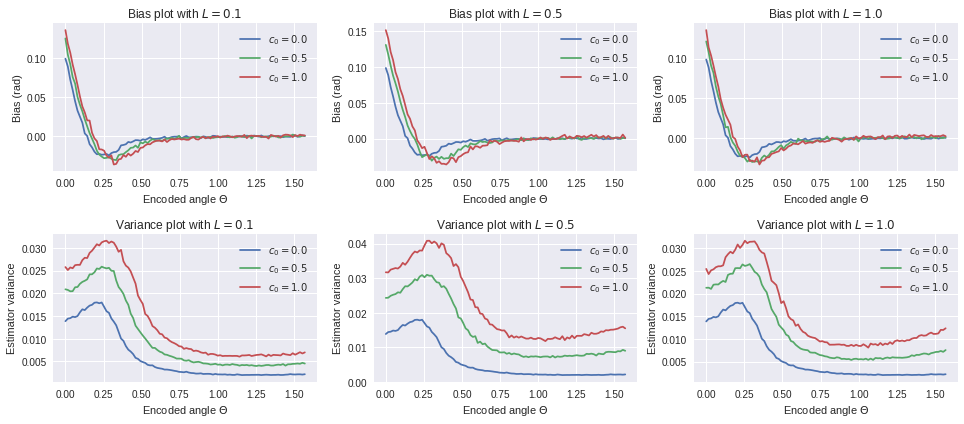

In [15]:
max_corr_plot = [0.0, 0.5, 1.0]

plt.rcParams['figure.figsize'] = (13.5, 6)

corr_length = 0.1
# Top-Left - Bias plot; L=0.1; c0={0.0,0.5,1.0}; Sim2
plt.subplot(231)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(0.0))
for max_corr in [0.5, 1.0]:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    biases = ML_ests_2[lbl][1]
    plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
plt.title('Bias plot with $L = {0}$'.format(corr_length))

# Bottom-Left - Variance plot; L=0.1; c0={0.0,0.5,1.0}; Sim2
plt.subplot(234)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$c_0 = 0.0$')
for max_corr in [0.5, 1.0]:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    variances = ML_ests_2[lbl][2]
    plt.plot(THETAS, variances, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $L = {0}$'.format(corr_length))


corr_length = 0.5
# Top-Middle - Bias plot; L=0.5; c0={0.0,0.5,1.0}; Sim1
plt.subplot(232) 
for max_corr in max_corr_plot:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    biases = ML_ests_1[lbl][1]
    plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
plt.title('Bias plot with $L = {0}$'.format(corr_length))

# Bottom-Middle - Variance plot; L=0.5; c0={0.0,0.5,1.0}; Sim1
plt.subplot(235) 
for max_corr in max_corr_plot:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    variances = ML_ests_1[lbl][2]
    plt.plot(THETAS, variances, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $L = {0}$'.format(corr_length))


corr_length = 1.0
# Top-Right - Bias plot; L=1.0; c0={0.0,0.5,1.0}; Sim2
plt.subplot(233)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(0.0))
for max_corr in [0.5, 1.0]:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    biases = ML_ests_2[lbl][1]
    plt.plot(THETAS, biases, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
plt.title('Bias plot with $L = {0}$'.format(corr_length))

# Bottom-Right - Variance plot; L=1.0; c0={0.0,0.5,1.0}; Sim2
plt.subplot(236)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$c_0 = 0.0$')
for max_corr in [0.5, 1.0]:
    lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
    variances = ML_ests_2[lbl][2]
    plt.plot(THETAS, variances, label='$c_0 = {0}$'.format(max_corr))
plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $L = {0}$'.format(corr_length))

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

In [16]:
# Extract biases & variances for given encoded angle and fixed max correlation for correlation lengths
def get_biases_vars_for_corr_lengths(max_corr, corr_length_arr, ML_ests, theta_idx=0):
    biases_corr_length = np.zeros(corr_length_arr.size)
    vars_corr_length = np.zeros(corr_length_arr.size)
    i = 0
    for corr_length in corr_length_arr:
        lbl = get_corr_param_dict_lbl(max_corr, corr_length)
        biases = ML_ests[lbl][1]
        variances = ML_ests[lbl][2]
        biases_corr_length[i] = biases[theta_idx]
        vars_corr_length[i] = variances[theta_idx]
        i += 1
    return (biases_corr_length, vars_corr_length)

### Small angle analysis

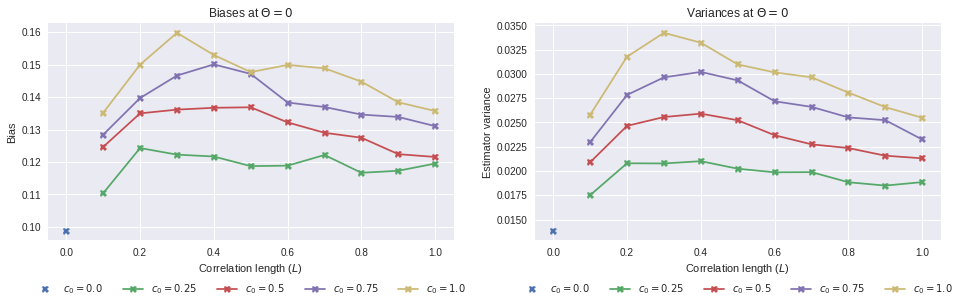

In [17]:
plt.rcParams['figure.figsize'] = (16, 4)

corr_length_arr = np.linspace(0.0, 1.0, 11)[1:]

plt.subplot(121) 
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(0.0, biases[0], 'X', label='$c_0 = 0.0$')

for max_corr in max_corr_arr:
    (biases, variances) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr, ML_ests_2)
    plt.plot(corr_length_arr, biases, '-X', label='$c_0 = {0}$'.format(max_corr))
    
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias')
plt.title('Biases at $\Theta = 0$')


plt.subplot(122) 
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(0.0, variances[0], 'X', label='$c_0 = 0.0$')

for max_corr in max_corr_arr:
    (biases, variances) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr, ML_ests_2)
    plt.plot(corr_length_arr, variances, '-X', label='$c_0 = {0}$'.format(max_corr))

plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.rcParams['figure.figsize'] = (10, 5)

The above plot shows that increasing the correlation length $L$ from 0.1 initially increases the bias for encoded angle $\Theta = 0$.

We see, however, that the bias starts to decrease as the correlation length is further increased.
This appears to be the case for maximum correlation values: $c_0 \in \{0.5, 0.75, 1.0\}$.

For the correlation length range used, the bias is always greater than the uncorrelated model.

We also observe a similar behaviour with the variance.

**Next simulation will evaluate the bias for increasing correlation lengths to determine if the bias continues to decrease.**

#### Simulation 4: greater correlation length values
* Max correlation: $c_0 = 1.0$
* Correlation length: $L \in [1,10]$ using logarithmic scale

In [5]:
max_corr = 1.0

corr_length_arr = np.logspace(start=0, stop=1, num=10)
corr_length_arr = np.round(corr_length_arr, 2)

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)

In [6]:
ML_ests_3 = ML_ests

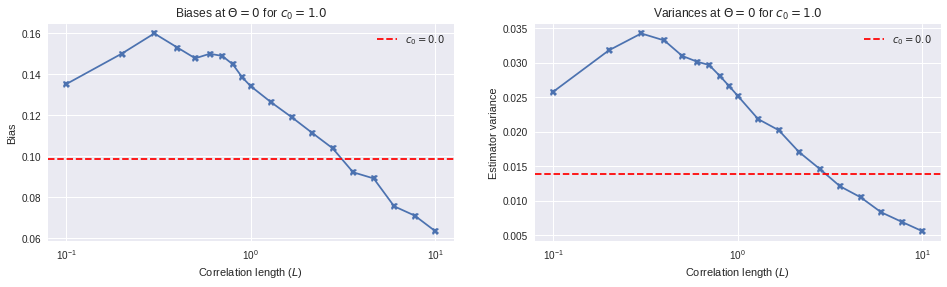

In [18]:
max_corr = 1.0

corr_length_arr_1 = np.linspace(0.0, 1.0, 11)[1:-1]
(biases_1, variances_1) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_1, ML_ests_2)

corr_length_arr_2 = np.logspace(start=0, stop=1, num=10)
corr_length_arr_2 = np.round(corr_length_arr_2, 2)
(biases_2, variances_2) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_2, ML_ests_3)

corr_length_arr = np.concatenate((corr_length_arr_1, corr_length_arr_2))
biases = np.concatenate((biases_1, biases_2))
variances = np.concatenate((variances_1, variances_2))

plt.rcParams['figure.figsize'] = (16, 4)

# Bias plot
plt.subplot(121) 
plt.plot(corr_length_arr, biases, '-X')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle='--', label='$c_0 = 0.0$')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias')
plt.title('Biases at $\Theta = 0$ for $c_0=1.0$')

# Variance plot
plt.subplot(122)
plt.plot(corr_length_arr, variances, '-X')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle='--', label='$c_0 = 0.0$')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$ for $c_0=1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

We can see that the bias and variance continue to decrease.

At approximately $L = 3.59$, the bias and variance are lower than that of the uncorrelated model.

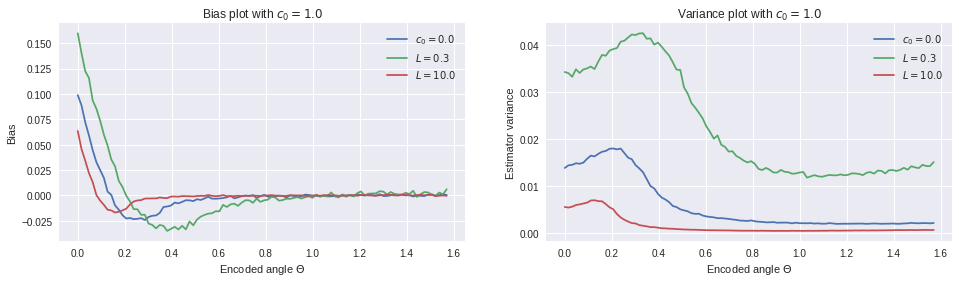

In [19]:
max_corr = 1.0
corr_length_arr = np.logspace(start=0, stop=1, num=10)
corr_length_arr = np.round(corr_length_arr_2, 2)

plt.rcParams['figure.figsize'] = (16, 4)

# Bias plot
plt.subplot(121) 

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$c_0 = 0.0$')

corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
biases = ML_ests_2[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

# idx = 5 # L=3.59 first results in bias/variance less than uncorrelated
# corr_length = corr_length_arr[idx]
# lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
# biases = ML_ests_3[lbl][1]
# plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[9]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
biases = ML_ests_3[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias')
plt.title('Bias plot with $c_0 = 1.0$')


# Variance plot
plt.subplot(122)

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$c_0 = 0.0$')

corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
variances = ML_ests_2[lbl][2]
plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))

# idx = 5 # L=3.59 first results in bias/variance less than uncorrelated
# corr_length = corr_length_arr[idx]
# lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
# variances = ML_ests_3[lbl][2]
# plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[9]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
variances = ML_ests_3[lbl][2]
plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))

plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $c_0 = 1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

As $L \to \infty$, the pairwise correlations approach $1$ (this can be clearly seen in the correlation matix visualisation above) thus resembling uniform correlations.

The characteristic shape of the bias and variance across values of encoded angle $\Theta$ remain even when pairwise correlations improve accuracy.

Distribution of estimates for true stimulus value 0


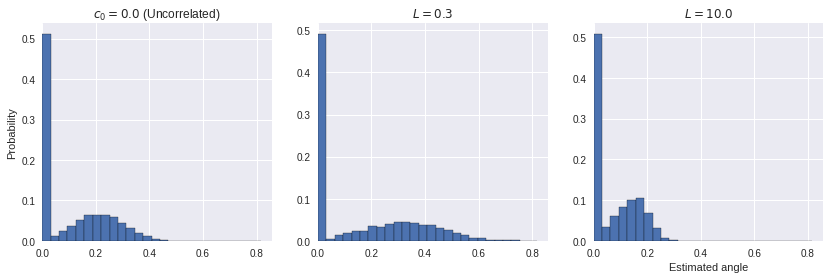

In [20]:
print('Distribution of estimates for true stimulus value 0')

plt.rcParams['figure.figsize'] = (14, 4)

max_corr = 1.0

plt.subplot(131)
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
est_dist = ML_ests_1[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:27], edgecolor='black')
plt.xlim(0)
plt.ylabel('Probability')
plt.title('$c_0 = 0.0$ (Uncorrelated)')


plt.subplot(132)
corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests_2[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:27], edgecolor='black')
plt.xlim(0)
plt.title('$L = {0}$'.format(corr_length))


plt.subplot(133)
corr_length = 10.0
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests_3[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:27], edgecolor='black')
plt.xlim(0)
plt.xlabel('Estimated angle')
plt.title('$L = {0}$'.format(corr_length))


plt.rcParams['figure.figsize'] = (10, 5)

**Simulation 5**

* Max correlation: $c_0 = 1.0$
* Correlation length: $L \in \{10^{-3}, ..., 10^{6}\}$ logarithmic scale

In [28]:
max_corr = 1.0

corr_length_arr = np.logspace(start=-3, stop=6, num=50)
corr_length_arr = np.round(corr_length_arr, 4)

corr_length_arr_1 = corr_length_arr[:10]
corr_length_arr_2 = corr_length_arr[10:20]
corr_length_arr_3 = corr_length_arr[20:30]
corr_length_arr_4 = corr_length_arr[30:40]
corr_length_arr_5 = corr_length_arr[40:]

In [29]:
corr_length_arr = corr_length_arr_1

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_4 = ML_ests

In [30]:
corr_length_arr = corr_length_arr_2

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_5 = ML_ests

In [31]:
corr_length_arr = corr_length_arr_3

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_6 = ML_ests

In [32]:
corr_length_arr = corr_length_arr_4

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_7 = ML_ests

In [33]:
corr_length_arr = corr_length_arr_5

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)
    
ML_ests_8 = ML_ests

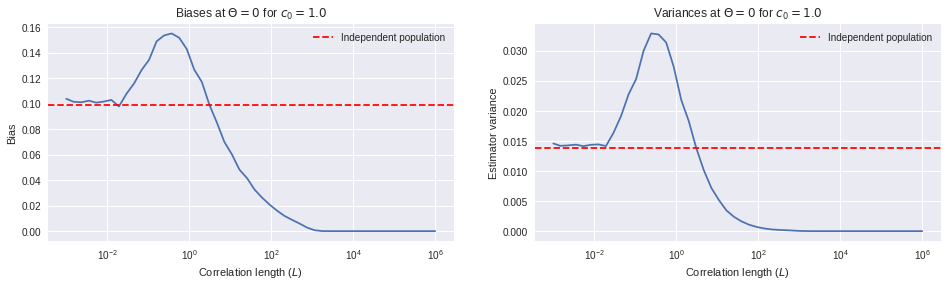

In [15]:
max_corr = 1.0

corr_length_arr = np.logspace(start=-3, stop=6, num=50)
corr_length_arr = np.round(corr_length_arr, 4)
corr_length_arr_1 = corr_length_arr[:10]
corr_length_arr_2 = corr_length_arr[10:20]
corr_length_arr_3 = corr_length_arr[20:30]
corr_length_arr_4 = corr_length_arr[30:40]
corr_length_arr_5 = corr_length_arr[40:]

(biases_1, variances_1) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_1, ML_ests_4)
(biases_2, variances_2) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_2, ML_ests_5)
(biases_3, variances_3) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_3, ML_ests_6)
(biases_4, variances_4) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_4, ML_ests_7)
(biases_5, variances_5) = get_biases_vars_for_corr_lengths(max_corr, corr_length_arr_5, ML_ests_8)


biases_theta = np.concatenate((biases_1, biases_2, biases_3, biases_4, biases_5))
variances_theta = np.concatenate((variances_1, variances_2, variances_3, variances_4, variances_5))


plt.rcParams['figure.figsize'] = (16, 4)

# Bias plot
plt.subplot(121) 

plt.plot(corr_length_arr, biases_theta, '-')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle='--', label='Independent population')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias')
plt.title('Biases at $\Theta = 0$ for $c_0=1.0$')

# Variance plot
plt.subplot(122)
plt.plot(corr_length_arr, variances_theta, '-')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle='--', label='Independent population')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$ for $c_0=1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

In [7]:
corr_length_arr = np.logspace(start=-3, stop=6, num=50)
corr_length_arr = np.round(corr_length_arr, 4)

max_bias = np.max(biases_theta)
idx_max_bias = np.argmax(biases_theta)
corr_length_max_bias = corr_length_arr[idx_max_bias]

max_var = np.max(variances_theta)
idx_max_var = np.argmax(variances_theta)
corr_length_max_var = corr_length_arr[idx_max_var]

print('Peak bias of {0:.3f} obtained at L = {1:.3f}'.format(max_bias,corr_length_max_bias))
print('Peak variance of {0:.3f} obtained at L = {1:.3f}'.format(max_var,corr_length_max_var))

Peak bias of 0.155 obtained at L = 0.373
Peak variance of 0.033 obtained at L = 0.244


Note: Starting from correlation length 25.6 and above, the bias/variance plot against encoded angles shows oscillations above and below 0.
This is caused by the candidate estimate space (i.e. parameter grid space) not being precise enough. Changing N_CAND_EST from 100 to 1000 fixes this and the bias/variance flatlines at zero as expected.
The reason this is only an issue for higher correlation lengths is that the corresponding population responses exhibit minimal lateral fluctuation from the mean population response 'profile', only fluctuations in amplitude which do not effect the ML estimate.
Thus, the decoding distributions for certain encoded angles show a single peak with high probability (sometimes also accompanied by shallower peaks with substantially smaller probabilities).
By increasing the precision of candidate estimates, this single peak aligns more closely to the true stimulus.

The effect on the bias/variance plot against correlation length (above) for encoded stimulus 0 shouldn't be too significant since 0.0 is one of the candidate estimates. 
However, plotting the decoding distribution for certain correlation lengths does not show clearly the bell-shaped component (which is only visible for larger N_CAND_EST).
The effect of this on the mean (which contributes to the bias) shouldn't be too critical.

**Interlude**

We used a circular correlation matrix for the experiments in this notebook despite the tuning curves of the population being non-circular.

Below we amended the correlation matrix to be non-circular and compared the results (ML-only):

In [20]:
max_corr = 1.0
corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)

biases_theta_ML = np.zeros(100)
variances_theta_ML = np.zeros(100)

for i in range(100):
    cov_mtx = construct_cov_matrix(max_corr, corr_length_arr[i])
    (biases_theta_ML[i], variances_theta_ML[i]) = get_ML_ests_stim_0(cov_mtx)
    print i

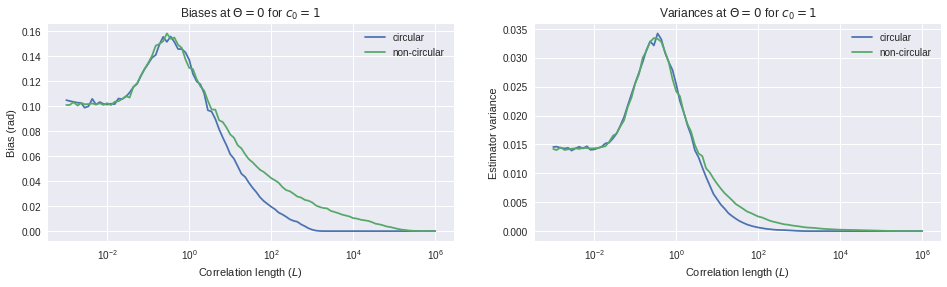

In [28]:
plt.rcParams['figure.figsize'] = (16, 4)

max_corr = 1.0
corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)

# Bias
plt.subplot(121)
plt.plot(corr_length_arr, biases_theta_1[5,:], '-', label='circular')
plt.plot(corr_length_arr, biases_theta_ML, label='non-circular')

plt.xscale('log')
plt.legend()
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$ for $c_0 = 1$')

# Variance
plt.subplot(122)
plt.plot(corr_length_arr, variances_theta_1[5,:], '-', label='circular')
plt.plot(corr_length_arr, variances_theta_ML, label='non-circular')

plt.xscale('log')
plt.legend()
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$ for $c_0 = 1$')

plt.rcParams['figure.figsize'] = (10, 5)

#### Simulation 6:
* Max correlation: $c_0 = \{0.1, 0.3, 0.5, 0.7, 0.9, 1.0\}$
* Correlation length: $L \in \{10^{-3}, ..., 10^{6}\}$ logarithmic scale

To reduce processing time, we only generate ML estimates for stimulus of 0.

In [23]:
def get_ML_ests_stim_0(cov_mtx, n_realisations=5000):
    estimate_dist = np.zeros(n_realisations)
    stim = 0.0

    # Generate noisy pop. responses by sampling multivariate distribution
    avg_pop_res = tuning_curve_theta(PREF_STIMS, stim)
    pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)

    # For each noisy response, compute error wrt candidate stimuli
    avg_tuning_curves = tuning_curve_theta(PREF_STIMS, CAND_ESTS[:,None])
    tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.inv(cov_mtx), axes=1 )
    errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))

    # Find minimum error stimuli for each realisation
    estimate_dist[:] = CAND_ESTS[errors.argmin(axis=0)]

    # Compute bias and variance
    mean_est = estimate_dist.mean()
    bias = mean_est - stim
    variance = ((estimate_dist - mean_est)**2).mean()

    return (bias, variance)

In [25]:
n_corr_lengths = 100
corr_length_arr = np.logspace(start=-3, stop=6, num=n_corr_lengths)
corr_length_arr = np.round(corr_length_arr, 4)
max_corr_arr = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

biases_theta_1 = np.zeros((len(max_corr_arr), n_corr_lengths))
variances_theta_1 = np.zeros((len(max_corr_arr), n_corr_lengths))

for i in range(len(max_corr_arr)):
    for j in range(n_corr_lengths):
        cov_mtx = construct_cov_matrix(max_corr_arr[i], corr_length_arr[j])
        (biases_theta_1[i,j], variances_theta_1[i,j]) = get_ML_ests_stim_0(cov_mtx)
        print i,j

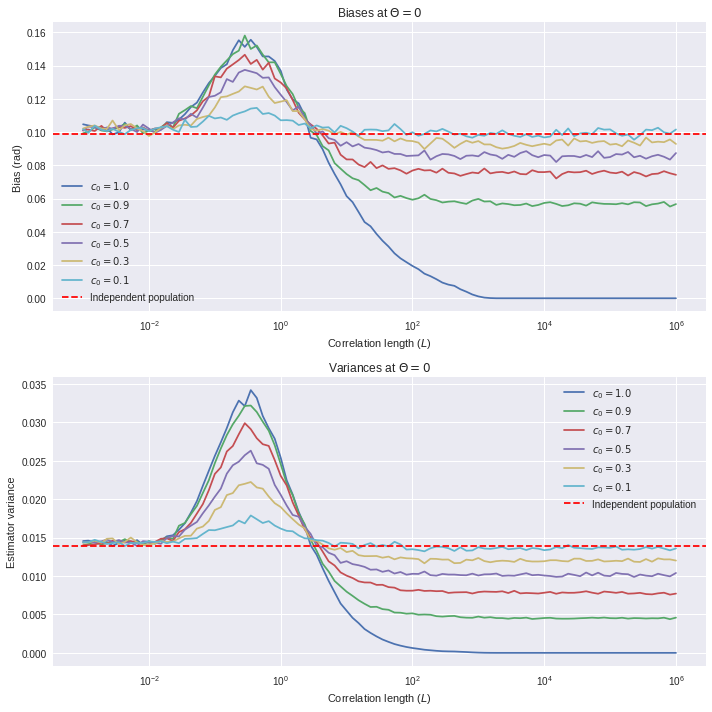

In [5]:
n_corr_lengths = 100
corr_length_arr = np.logspace(start=-3, stop=6, num=n_corr_lengths)
corr_length_arr = np.round(corr_length_arr, 4)
max_corr_arr = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

plt.rcParams['figure.figsize'] = (10, 10)

# Bias plot
plt.subplot(211) 

plt.plot(corr_length_arr, biases_theta_1[5,:], '-', label='$c_0 = 1.0$')
plt.plot(corr_length_arr, biases_theta_1[4,:], '-', label='$c_0 = 0.9$')
plt.plot(corr_length_arr, biases_theta_1[3,:], '-', label='$c_0 = 0.7$')
plt.plot(corr_length_arr, biases_theta_1[2,:], '-', label='$c_0 = 0.5$')
plt.plot(corr_length_arr, biases_theta_1[1,:], '-', label='$c_0 = 0.3$')
plt.plot(corr_length_arr, biases_theta_1[0,:], '-', label='$c_0 = 0.1$')


lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle='--', label='Independent population')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

# Variance plot
plt.subplot(212)

plt.plot(corr_length_arr, variances_theta_1[5,:], '-', label='$c_0 = 1.0$')
plt.plot(corr_length_arr, variances_theta_1[4,:], '-', label='$c_0 = 0.9$')
plt.plot(corr_length_arr, variances_theta_1[3,:], '-', label='$c_0 = 0.7$')
plt.plot(corr_length_arr, variances_theta_1[2,:], '-', label='$c_0 = 0.5$')
plt.plot(corr_length_arr, variances_theta_1[1,:], '-', label='$c_0 = 0.3$')
plt.plot(corr_length_arr, variances_theta_1[0,:], '-', label='$c_0 = 0.1$')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle='--', label='Independent population')
plt.legend()

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

The above plots show the bias and variance for encoded angle $\Theta = 0$ across correlation length for different values of $c_0$.
These were inspired by figure 2 of (Sompolinsky et al., 2001).

### Computing estimate distribution in a numerically exact way

The probability distribution over candidate estimates for a given encoded angle, $P(\theta | \Theta)$, can be computed in a numerically exact way using a Gaussian Process approach (as explained in the referenced paper).
From the estimate distribution, the bias and variance can be calculated.

Below, we seek to validate the accuracy of this approach by comparing it to our maximum likelihood simulations for the case of correlated noise.

The estimate distributions are generated using the function `est_p_cor()` from the `DeDist` package (S. Keemink) by passing the constructed covariance matrix of our noise model as an argument.

In [66]:
def tuning_curve_theta_dedist(pref_stim, opening_angle, par):
    return tuning_curve_theta(pref_stim, opening_angle)

def get_GP_ests(cov_mtx):
    prob_dists = np.zeros((N_THETAS, N_CAND_ESTS))
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)

    fun = tuning_curve_theta_dedist
    for i in range(N_THETAS):
        stim = THETAS[i]

        prob_dist = dedist.est_p_cor(fun, stim, 0, cov_mtx, PREF_STIMS, CAND_ESTS, verbose=False)

        mean_est = np.sum(prob_dist * CAND_ESTS) / np.sum(prob_dist)
        biases[i] = mean_est - stim
        variances[i] = np.sum(prob_dist * CAND_ESTS * CAND_ESTS) / np.sum(prob_dist) - mean_est**2

        prob_dists[i,:] = np.asarray(prob_dist)
        
    return [prob_dists, biases, variances]

def get_GP_ests_stim_0(cov_mtx):
    stim = 0.0
    
    fun = tuning_curve_theta_dedist
    prob_dist = dedist.est_p_cor(fun, stim, 0, cov_mtx, PREF_STIMS, CAND_ESTS, verbose=False)

    mean_est = np.sum(prob_dist * CAND_ESTS) / np.sum(prob_dist)
    bias = mean_est - stim
    var = np.sum(prob_dist * CAND_ESTS * CAND_ESTS) / np.sum(prob_dist) - mean_est**2
    
    return (bias, var)

#### Experiment 1

* Uncorrelated model ($c_0 = 0$)
* $c_0 = 1.0$ with $L \in \{0.3, 10.0\}$

In [29]:
GP_ests_1 = dict()

# Uncorrelated
max_corr = 0.0
corr_length = 1.0
cov_mtx = construct_cov_matrix(max_corr, corr_length)
lbl = get_corr_param_dict_lbl(max_corr, corr_length)
GP_ests_1[lbl] = get_GP_ests(cov_mtx)

max_corr = 1.0
corr_length = 0.3
cov_mtx = construct_cov_matrix(max_corr, corr_length)
lbl = get_corr_param_dict_lbl(max_corr, corr_length)
GP_ests_1[lbl] = get_GP_ests(cov_mtx)

max_corr = 1.0
corr_length = 10.0
cov_mtx = construct_cov_matrix(max_corr, corr_length)
lbl = get_corr_param_dict_lbl(max_corr, corr_length)
GP_ests_1[lbl] = get_GP_ests(cov_mtx)

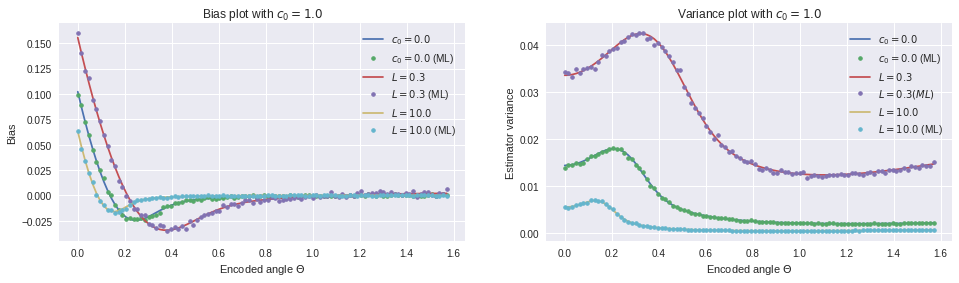

In [7]:
max_corr = 1.0

plt.rcParams['figure.figsize'] = (16, 4)

# Bias plot
plt.subplot(121) 

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
biases = GP_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$c_0 = 0.0$')
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
biases = ML_ests_1[lbl][1]
plt.plot(THETAS, biases, '.', mew=1, label='$c_0 = 0.0$ (ML)')

corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
biases = GP_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))
biases = ML_ests_2[lbl][1]
plt.plot(THETAS, biases, '.', mew=1, label='$L = {0}$ (ML)'.format(corr_length))

corr_length = 10.0
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
biases = GP_ests_1[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))
biases = ML_ests_3[lbl][1]
plt.plot(THETAS, biases, '.', mew=1, label='$L = {0}$ (ML)'.format(corr_length))

plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias')
plt.title('Bias plot with $c_0 = 1.0$')

# Variance plot
plt.subplot(122)

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
variances = GP_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$c_0 = 0.0$')
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=0.5)
variances = ML_ests_1[lbl][2]
plt.plot(THETAS, variances, '.', mew=1, label='$c_0 = 0.0$ (ML)')

corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
variances = GP_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))
variances = ML_ests_2[lbl][2]
plt.plot(THETAS, variances, '.', mew=1, label='$L = {0} (ML)$'.format(corr_length))

corr_length = 10.0
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
variances = GP_ests_1[lbl][2]
plt.plot(THETAS, variances, label='$L = {0}$'.format(corr_length))
variances = ML_ests_3[lbl][2]
plt.plot(THETAS, variances, '.', mew=1, label='$L = {0}$ (ML)'.format(corr_length))

plt.legend()
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')
plt.title('Variance plot with $c_0 = 1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

The above plots show the bias and variance across encoded angles for different correlation lengths as well as the uncorrelated model (similar to a previous plot).

They confirm that the GP approach compares well to the ML simulations.

Next, we will compare the estimate distributions for the $L = 0.3$ model above for encoded angles $0.0, 0.4, 0.8$.

Model with correlation parameters: c0 = 1.0, L = 0.3


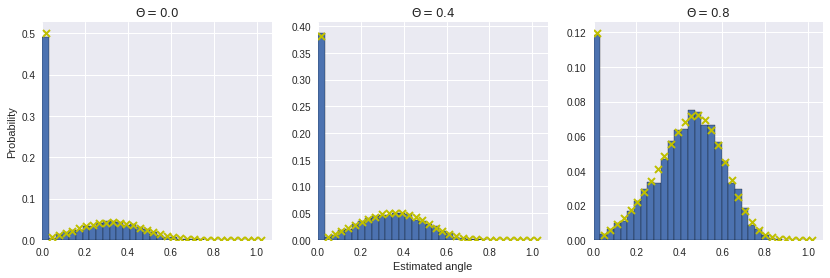

In [6]:
plt.rcParams['figure.figsize'] = (14, 4)

max_corr = 1.0
corr_length = 0.3
lbl = get_corr_param_dict_lbl(max_corr, corr_length)

print('Model with correlation parameters: c0 = 1.0, L = 0.3')

upper_cand_est_idx = 33
diff_cand_est = (CAND_ESTS[1] - CAND_ESTS[0]) / 2

# Theta 0.0
plt.subplot(131)
theta_idx = 0

est_dist = ML_ests_2[lbl][theta_idx][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:upper_cand_est_idx], edgecolor='black')

prob_dist = GP_ests_1[lbl][0][theta_idx,:upper_cand_est_idx]
plt.plot(CAND_ESTS[:upper_cand_est_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')

plt.xlim(0)
plt.ylabel('Probability')
plt.title('$\Theta = 0.0$')

# Theta 0.4
plt.subplot(132)
theta_idx = 13

est_dist = ML_ests_2[lbl][0][theta_idx,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:upper_cand_est_idx], edgecolor='black')

prob_dist = GP_ests_1[lbl][0][theta_idx,:upper_cand_est_idx]
plt.plot(CAND_ESTS[:upper_cand_est_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')

plt.xlim(0)
plt.xlabel('Estimated angle')
plt.title('$\Theta = 0.4$')

# Theta 0.8
plt.subplot(133)
theta_idx = 26

est_dist = ML_ests_2[lbl][0][theta_idx,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:upper_cand_est_idx], edgecolor='black')

prob_dist = GP_ests_1[lbl][0][theta_idx,:upper_cand_est_idx]
plt.plot(CAND_ESTS[:upper_cand_est_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')

plt.xlim(0)
plt.title('$\Theta = 0.8$')

plt.rcParams['figure.figsize'] = (10, 5)

#### Experiment 2

* Max correlation: $c_0 = \{0.1, 0.3, 0.5, 0.7, 0.9, 1.0\}$
* Correlation length: $L \in \{10^{-3}, ..., 10^{6}\}$ logarithmic scale

We shall only generate the bias and variance at $\Theta = 0$ to speed up processing time and reduce memory required.

In [35]:
n_corr_lengths = 100
corr_length_arr = np.logspace(start=-3, stop=6, num=n_corr_lengths)
corr_length_arr = np.round(corr_length_arr, 4)
max_corr_arr = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

biases_theta_GP = np.zeros((len(max_corr_arr), n_corr_lengths))
variances_theta_GP = np.zeros((len(max_corr_arr), n_corr_lengths))

for i in range(len(max_corr_arr)):
    for j in range(n_corr_lengths):
        cov_mtx = construct_cov_matrix(max_corr_arr[i], corr_length_arr[j])
        (biases_theta_GP[i,j], variances_theta_GP[i,j]) = get_GP_ests_stim_0(cov_mtx)
        print i,j

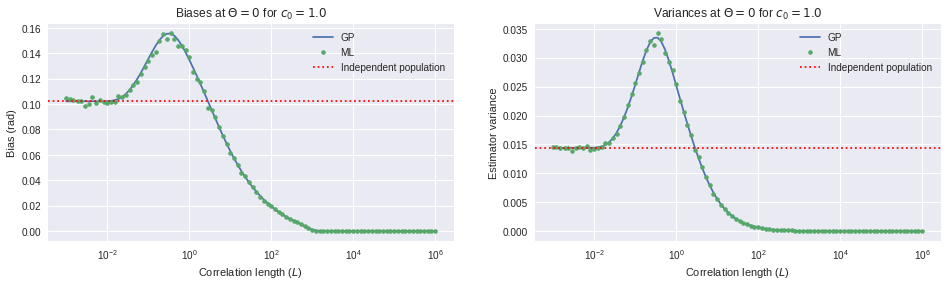

In [5]:
plt.rcParams['figure.figsize'] = (16, 4)

max_corr = 1.0
max_corr_idx = 5 # c0 = 1.0

corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)

# Bias plot
plt.subplot(121) 

biases = biases_theta_GP[max_corr_idx, :]
plt.plot(corr_length_arr, biases, label='GP')
plt.plot(corr_length_arr, biases_theta_1[max_corr_idx,:], '.', mew=1, label='ML')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
biases = GP_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle=':', label='Independent population')

plt.legend()
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$ for $c_0=1.0$')

# Variance plot
plt.subplot(122)

variances = variances_theta_GP[max_corr_idx, :]
plt.plot(corr_length_arr, variances, label='GP')
plt.plot(corr_length_arr, variances_theta_1[max_corr_idx,:], '.', mew=1, label='ML')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
variances = GP_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle=':', label='Independent population')

plt.legend()
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$ for $c_0=1.0$')

plt.rcParams['figure.figsize'] = (10, 5)

In [159]:
lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
biases = GP_ests_1[lbl][1]
variances = GP_ests_1[lbl][2]

print 'Independent population bias value: {0:.4f}'.format(biases[0])
print 'Independent population variance value: {0:.4f}'.format(variances[0])

Independent population bias value: 0.1022
Independent population variance value: 0.0144


In [58]:
corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)

idx = 38
print 'Correlation length: {0}'.format(corr_length_arr[idx])
print 'Bias: {0:.4f}'.format(biases_theta_GP[5,idx])
print 'Variance: {0:.4f}'.format(variances_theta_GP[5,idx])

Correlation length: 2.848
Bias: 0.1023
Variance: 0.0145


In [44]:
corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)

biases = biases_theta_GP[5,:]
max_bias = np.max(biases)
idx_max_bias = np.argmax(biases)
corr_length_max_bias = corr_length_arr[idx_max_bias]

variances = variances_theta_GP[5,:]
max_var = np.max(variances)
idx_max_var = np.argmax(variances)
corr_length_max_var = corr_length_arr[idx_max_var]

print('Peak bias of {0:.3f} obtained at L = {1:.4f}'.format(max_bias,corr_length_max_bias))
print('Peak variance of {0:.3f} obtained at L = {1:.4f}'.format(max_var,corr_length_max_var))

Peak bias of 0.155 obtained at L = 0.3511
Peak variance of 0.033 obtained at L = 0.3511


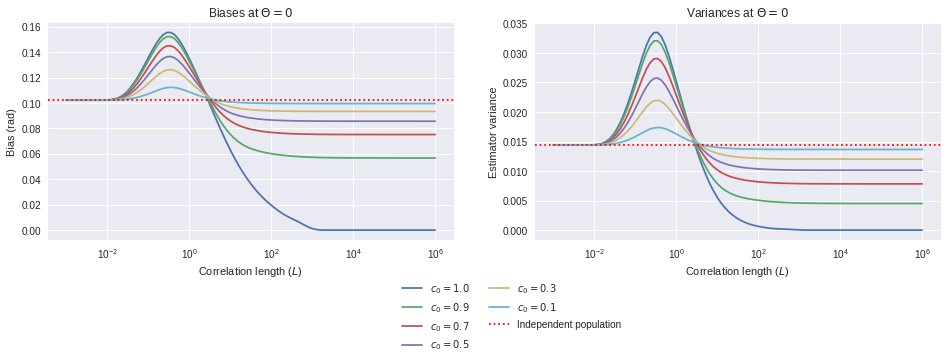

In [16]:
plt.rcParams['figure.figsize'] = (16, 4)

corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)
max_corr_arr = np.asarray([0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

# Bias plot
plt.subplot(121)

plt.plot(corr_length_arr, biases_theta_GP[5,:], '-', label='$c_0 = 1.0$')
plt.plot(corr_length_arr, biases_theta_GP[4,:], '-', label='$c_0 = 0.9$')
plt.plot(corr_length_arr, biases_theta_GP[3,:], '-', label='$c_0 = 0.7$')
plt.plot(corr_length_arr, biases_theta_GP[2,:], '-', label='$c_0 = 0.5$')
plt.plot(corr_length_arr, biases_theta_GP[1,:], '-', label='$c_0 = 0.3$')
plt.plot(corr_length_arr, biases_theta_GP[0,:], '-', label='$c_0 = 0.1$')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
biases = GP_ests_1[lbl][1]
plt.axhline(y=biases[0], color='r', linestyle=':', label='Independent population')

plt.legend(loc=2, bbox_to_anchor=(0.85, -0.15), ncol=2)


plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

# Variance plot
plt.subplot(122)

plt.plot(corr_length_arr, variances_theta_GP[5,:], '-', label='$c_0 = 1.0$')
plt.plot(corr_length_arr, variances_theta_GP[4,:], '-', label='$c_0 = 0.9$')
plt.plot(corr_length_arr, variances_theta_GP[3,:], '-', label='$c_0 = 0.7$')
plt.plot(corr_length_arr, variances_theta_GP[2,:], '-', label='$c_0 = 0.5$')
plt.plot(corr_length_arr, variances_theta_GP[1,:], '-', label='$c_0 = 0.3$')
plt.plot(corr_length_arr, variances_theta_GP[0,:], '-', label='$c_0 = 0.1$')

lbl = get_corr_param_dict_lbl(max_corr=0.0, corr_length=1.0) # Uncorrelated case
variances = GP_ests_1[lbl][2]
plt.axhline(y=variances[0], color='r', linestyle=':', label='Independent population')

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.rcParams['figure.figsize'] = (10, 5)

### Impact of population size on bias

Literature has shown the fisher information to increase linearly with the number of neurons in the population but saturates in the presence of correlated noise ([Sompolinsky et. al, 2001](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.64.051904))

We shall investigate the relationship between the bias at encoded opening angle 0 and increasing number of neurons.
This will be done for different values of the correlation length.

We will use both the ML estimator and the GP approach to evaluate the bias/variance.

The preferred orientations of the neurons for a given population size will be uniformly distributed in the stimulus range $[-\pi, \pi]$.

In [15]:
# Changed allocation of preferred orientations back to 'original' format
# with upper bound +pi not included

def construct_corr_matrix_new(max_corr, corr_length, n_neurons):
#     pref_stims = np.linspace(-pi, pi, n_neurons)
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    
    pref_ang_dists = pref_stims - pref_stims[:,None]
    pref_ang_dists = absolute(angle(exp(1j * pref_ang_dists)))
    
    return max_corr * (exp(-pref_ang_dists / corr_length) - eye(n_neurons)) + eye(n_neurons)

def construct_cov_matrix_new(max_corr=1.0, corr_length=0.5, n_neurons=100):
    corr_mtx = construct_corr_matrix_new(max_corr, corr_length, n_neurons)
    stds_mtx = NOISE_SIGMA * eye(n_neurons) # matrix of standard deviations
    return dot(stds_mtx, dot(corr_mtx, stds_mtx))

def get_ML_ests_stim_0_new(n_neurons, cov_mtx, n_realisations=5000):
    if n_neurons == 1:
        pref_stims = np.asarray([0])
    else:
#         pref_stims = np.linspace(-pi, pi, n_neurons)
        pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    stim = 0.0
        
    estimate_dist = np.zeros(n_realisations)

    # Generate noisy pop. responses by sampling multivariate distribution
    avg_pop_res = tuning_curve_theta(pref_stims, stim)
    pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)

    # For each noisy response, compute error wrt candidate stimuli
    avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None])
    tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.inv(cov_mtx), axes=1 )
    errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))

    # Find minimum error stimuli for each realisation
    estimate_dist[:] = CAND_ESTS[errors.argmin(axis=0)]

    # Compute bias and variance
    mean_est = estimate_dist.mean()
    bias = mean_est - stim
    variance = ((estimate_dist - mean_est)**2).mean()

    return (bias, variance)

def get_GP_ests_stim_0_new(n_neurons, cov_mtx):
    if n_neurons == 1:
        pref_stims = np.asarray([0])
    else:
#         pref_stims = np.linspace(-pi, pi, n_neurons)
        pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    stim = 0.0
    
    fun = tuning_curve_theta_dedist
    prob_dist = dedist.est_p_cor(fun, stim, 0, cov_mtx, pref_stims, CAND_ESTS, verbose=False)

    mean_est = np.sum(prob_dist * CAND_ESTS) / np.sum(prob_dist)
    bias = mean_est - stim
    var = np.sum(prob_dist * CAND_ESTS * CAND_ESTS) / np.sum(prob_dist) - mean_est**2
    
    return (bias, var)

#### Experiment 1 - Independent model

We start with the independent (uncorrelated) model with the following range for popoulation size: $[1,500]$

It is expected that the bias approaches 0 for increasing neurons (why?).

In [28]:
n_neurons_low = 2
n_neurons_upper = 501

n_neurons_arr = np.arange(n_neurons_low, n_neurons_upper)

biases_neurons_ind_ML = np.zeros(len(n_neurons_arr))
variances_neurons_ind_ML = np.zeros(len(n_neurons_arr))

biases_neurons_ind_GP = np.zeros(len(n_neurons_arr))
variances_neurons_ind_GP = np.zeros(len(n_neurons_arr))

for i in range(len(n_neurons_arr)):
    cov_mtx = construct_cov_matrix_new(max_corr=0.0, n_neurons=n_neurons_arr[i])
    (biases_neurons_ind_ML[i], variances_neurons_ind_ML[i]) = get_ML_ests_stim_0_new(n_neurons_arr[i], cov_mtx)
    (biases_neurons_ind_GP[i], variances_neurons_ind_GP[i]) = get_GP_ests_stim_0_new(n_neurons_arr[i], cov_mtx)

In [52]:
# Running experiment for n_neurons=1 (not included in range first time round)
n_neurons = 1
cov_mtx = construct_cov_matrix_new(max_corr=0.0, n_neurons=n_neurons)

(biases_neurons_ind_ML_1, variances_neurons_ind_ML_1) = get_ML_ests_stim_0_new(n_neurons, cov_mtx)
(biases_neurons_ind_GP_1, variances_neurons_ind_GP_1) = get_GP_ests_stim_0_new(n_neurons, cov_mtx)

In [59]:
# # Insert result for n_neurons=1 to the other results
# biases_neurons_ind_ML = np.insert(biases_neurons_ind_ML, 0, biases_neurons_ind_ML_1)
# variances_neurons_ind_ML = np.insert(variances_neurons_ind_ML, 0, variances_neurons_ind_ML_1)

# biases_neurons_ind_GP = np.insert(biases_neurons_ind_GP, 0, biases_neurons_ind_GP_1)
# variances_neurons_ind_GP = np.insert(variances_neurons_ind_GP, 0, variances_neurons_ind_GP_1)

In [344]:
n_neurons = 1
cov_mtx = construct_cov_matrix_new(max_corr=1.0, corr_length=0.3511, n_neurons=n_neurons)

(biases_neurons_corr_ML_1, variances_neurons_corr_ML_1) = get_ML_ests_stim_0_new(n_neurons, cov_mtx)
(biases_neurons_corr_GP_1, variances_neurons_corr_GP_1) = get_GP_ests_stim_0_new(n_neurons, cov_mtx)

In [349]:
# biases_neurons_corr_ML = np.insert(biases_neurons_corr_ML, 0, biases_neurons_corr_ML_1)
# variances_neurons_corr_ML = np.insert(variances_neurons_corr_ML, 0, variances_neurons_corr_ML_1)

# biases_neurons_corr_GP = np.insert(biases_neurons_corr_GP, 0, biases_neurons_corr_GP_1)
# variances_neurons_corr_GP = np.insert(variances_neurons_corr_GP, 0, variances_neurons_corr_GP_1)

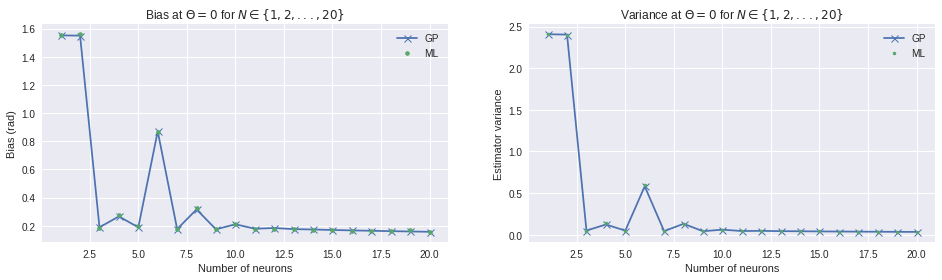

In [7]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

upper_idx = 20

plt.subplot(121)
plt.plot(n_neurons_arr[:upper_idx], biases_neurons_ind_GP[:upper_idx], '-x', mew=1, label='GP')
plt.plot(n_neurons_arr[:upper_idx], biases_neurons_ind_ML[:upper_idx], '.', mew=1, label='ML')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')
plt.title('Bias at $\Theta=0$ for $N \in \{1,2,...,20\}$')

plt.subplot(122)
plt.plot(n_neurons_arr[:upper_idx], variances_neurons_ind_GP[:upper_idx], '-x', mew=1, label='GP')
plt.plot(n_neurons_arr[:upper_idx], variances_neurons_ind_ML[:upper_idx], '.', label='ML')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$ for $N \in \{1,2,...,20\}$')

plt.rcParams['figure.figsize'] = (10, 5)

The bias and variance plots above show uncharacteristic behaviour for small population sizes (i.e. between 1 and 11 neurons).

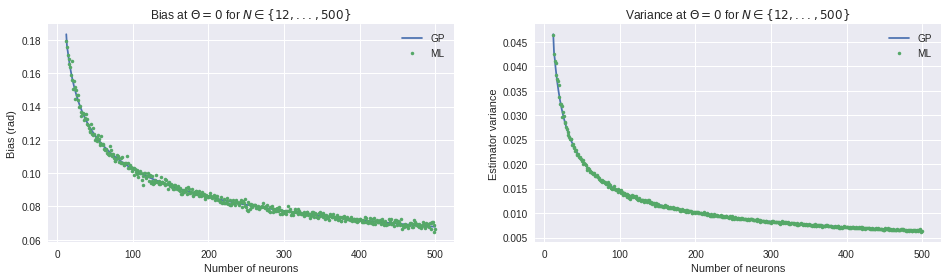

In [225]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 11

plt.subplot(121)
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_ind_GP[skip_idx:], label='GP')
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_ind_ML[skip_idx:], '.', label='ML')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')
plt.title('Bias at $\Theta=0$ for $N \in \{12,...,500\}$')

plt.subplot(122)
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_ind_GP[skip_idx:], label='GP')
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_ind_ML[skip_idx:], '.', label='ML')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$ for $N \in \{12,...,500\}$')

plt.rcParams['figure.figsize'] = (10, 5)

* If we plot the bias/variance starting from population size 12, we obtain the expected behaviour.
* The bias and variance strictly decrease for increasing number of neurons.
    * The bias/variance will eventually reach zero for $N > 500$
* It is also worth noting that the GP and ML approaches closely align (within 2dp).
    * The GP approach gives a smooth curve

**TODO: Repeat independent model simulation for $N > 500$**

We revert our attention to investigating the uncharacteristic behaviour of bias and variance for small population sizes.

We will look at the tuning curves of the neurons as well as the consequent mean population responses.

Although our system involves a multivariate stimulus, the tuning curves can be plotted since we are only evaluating the bias and variance at opening angle 0.
By the linear coding model, this is equivalent to twice the univariate tuning curve.

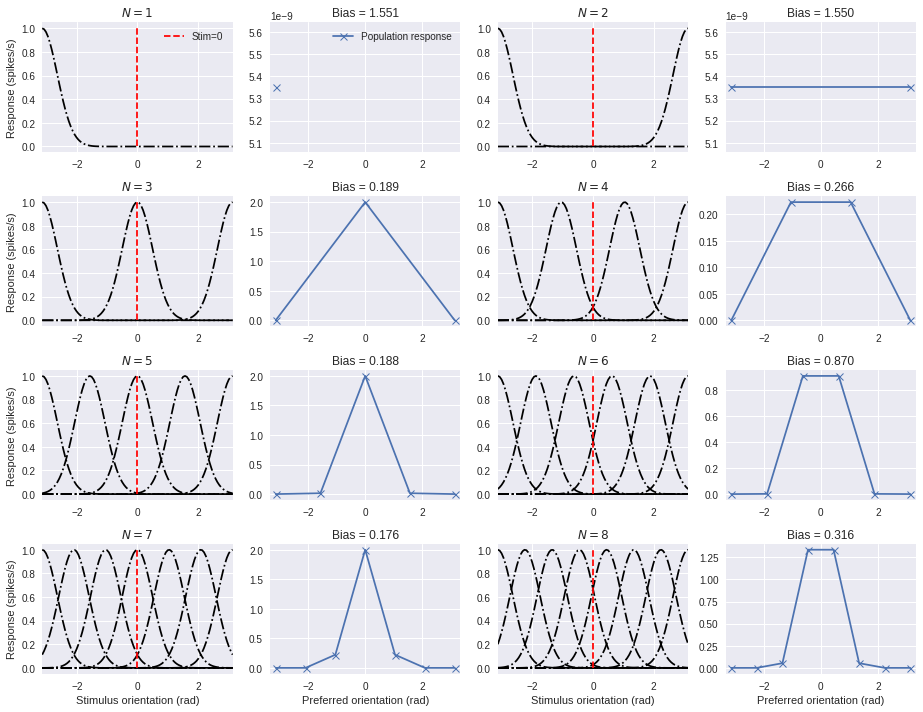

In [6]:
plt.rcParams['figure.figsize'] = (13, 10)

stim_space = np.linspace(-pi, pi, N_NEURONS+1)

plt.subplot(441)
pref_stims = np.linspace(-pi, pi, 1)

for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red', label='Stim=0')
plt.legend()
plt.xlim([-pi, pi])
plt.ylabel('Response (spikes/s)')
plt.title('$N = 1$')

plt.subplot(442)
plt.plot(pref_stims, tuning_curve_theta(pref_stims, 0), '-x', mew=1, label='Population response')
plt.legend()
plt.xlim([-pi-0.2, pi+0.2])
plt.title('Bias = {0:.3f}'.format(biases_neurons_ind_GP[0]))


plt.subplot(443)
pref_stims = np.linspace(-pi, pi, 2)

for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.xlim([-pi, pi])
plt.title('$N = 2$')

plt.subplot(444)
plt.plot(pref_stims, tuning_curve_theta(pref_stims, 0), '-x', mew=1)
plt.xlim([-pi-0.2, pi+0.2])
plt.title('Bias = {0:.3f}'.format(biases_neurons_ind_GP[1]))


plt.subplot(445)
pref_stims = np.linspace(-pi, pi, 3)

for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.xlim([-pi, pi])
plt.ylabel('Response (spikes/s)')
plt.title('$N = 3$')

plt.subplot(446)
plt.plot(pref_stims, tuning_curve_theta(pref_stims, 0), '-x', mew=1)
plt.xlim([-pi-0.2, pi+0.2])
plt.title('Bias = {0:.3f}'.format(biases_neurons_ind_GP[2]))


plt.subplot(447)
pref_stims = np.linspace(-pi, pi, 4)

for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.xlim([-pi, pi])
plt.title('$N = 4$')

plt.subplot(448)
plt.plot(pref_stims, tuning_curve_theta(pref_stims, 0), '-x', mew=1)
plt.xlim([-pi-0.2, pi+0.2])
plt.title('Bias = {0:.3f}'.format(biases_neurons_ind_GP[3]))


plt.subplot(449)
pref_stims = np.linspace(-pi, pi, 5)

for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.xlim([-pi, pi])
plt.ylabel('Response (spikes/s)')
plt.title('$N = 5$')

plt.subplot(4,4,10)
plt.plot(pref_stims, tuning_curve_theta(pref_stims, 0), '-x', mew=1)
plt.xlim([-pi-0.2, pi+0.2])
plt.title('Bias = {0:.3f}'.format(biases_neurons_ind_GP[4]))


plt.subplot(4,4,11)
pref_stims = np.linspace(-pi, pi, 6)

for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.xlim([-pi, pi])
plt.title('$N = 6$')

plt.subplot(4,4,12)
plt.plot(pref_stims, tuning_curve_theta(pref_stims, 0), '-x', mew=1)
plt.xlim([-pi-0.2, pi+0.2])
plt.title('Bias = {0:.3f}'.format(biases_neurons_ind_GP[5]))


plt.subplot(4,4,13)
pref_stims = np.linspace(-pi, pi, 7)

for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.xlim([-pi, pi])
plt.ylabel('Response (spikes/s)')
plt.xlabel('Stimulus orientation (rad)')
plt.title('$N = 7$')

plt.subplot(4,4,14)
plt.plot(pref_stims, tuning_curve_theta(pref_stims, 0), '-x', mew=1)
plt.xlim([-pi-0.2, pi+0.2])
plt.title('Bias = {0:.3f}'.format(biases_neurons_ind_GP[6]))
plt.xlabel('Preferred orientation (rad)')


plt.subplot(4,4,15)
pref_stims = np.linspace(-pi, pi, 8)

for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.xlim([-pi, pi])
plt.title('$N = 8$')
plt.xlabel('Stimulus orientation (rad)')

plt.subplot(4,4,16)
plt.plot(pref_stims, tuning_curve_theta(pref_stims, 0), '-x', mew=1)
plt.xlim([-pi-0.2, pi+0.2])
plt.title('Bias = {0:.3f}'.format(biases_neurons_ind_GP[7]))
plt.xlabel('Preferred orientation (rad)')


plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

* It is clear that we attain a smaller bias when there exists a neuron in the population with preferred orientation 0.
    * This is the case for odd $N \geq 3$.

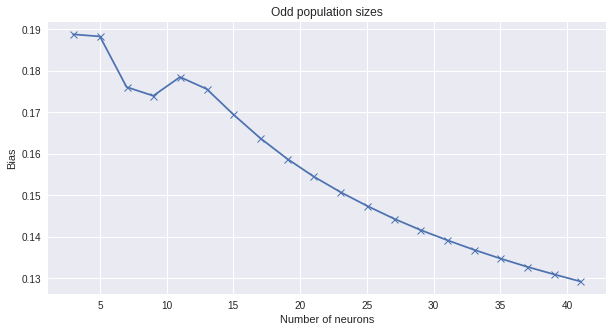

In [257]:
n_neurons_upper = 501

n_neurons_arr = np.arange(1, n_neurons_upper)
odd_nrn_filter = np.arange(2, 500, 2)

plt.plot(n_neurons_arr[odd_nrn_filter][:20], biases_neurons_ind_GP[odd_nrn_filter][:20], '-x', mew=1)
plt.xlabel('Number of neurons')
plt.ylabel('Bias')
plt.title('Odd population sizes')

The above plot is for odd $N \geq 3$.

The bias is not smooth between N = 3 and 11, in particular the bias increases from N = 9 to 11.

Evidently, by simply assigning the preferred orientations uniformly in the stimulus space, the populations (represented by the neurons' preferred orientations) differ for population sizes increasing in intervals of 1 or 2.

This is not an issue for $N \geq 12$ as the populations are densely populated.

N = 5: [-3.14159265 -1.57079633  0.          1.57079633  3.14159265]

N = 9: [-3.14159265 -2.35619449 -1.57079633 -0.78539816  0.          0.78539816
  1.57079633  2.35619449  3.14159265]


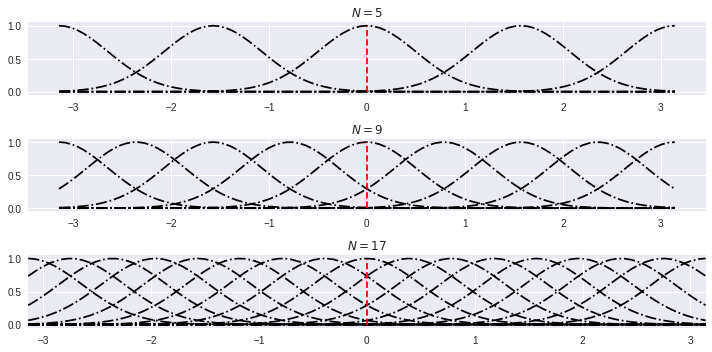

In [277]:
plt.subplot(3,1,1)
pref_stims = np.linspace(-pi, pi, 5)
for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.title('$N = 5$')

plt.subplot(3,1,2)
pref_stims = np.linspace(-pi, pi, 9)
for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.title('$N = 9$')

plt.subplot(3,1,3)
pref_stims = np.linspace(-pi, pi, 17)
for pref_stim in pref_stims:
    plt.plot(stim_space, tuning_curve(pref_stim, stim_space), '-.', color='black')
plt.plot((0, 0), (0, 1), '--', color='red')
plt.xlim([-pi, pi])
plt.title('$N = 17$')

plt.tight_layout()

pref_stims = np.linspace(-pi, pi, 5)
print 'N = 5:', pref_stims
print ''
pref_stims = np.linspace(-pi, pi, 9)
print 'N = 9:', pref_stims

Ideally, we would like the populations to satisfy the following constraints:
* Uniformly distributed tuning curves
* Exists a tuning curve at 0
* Populations must be supersets of each other for increasing sizes

However, this would significantly restrict the number of possible population sizes we can evaluate:
$N \in \{1, 3, 5, 9, 17, 33, ...\}$

#### Experiment 2 - Correlated model (L with peak bias)

We move on to a model with noise correlations; again evaluating for population size range: $[1,500]$

The literature indicates that the bias should saturate for increasing N.

We shall fix $c_0$ to 1 and vary the correlation length.

Firstly, we will run the model with $L = 0.3511$.
This model gave the largest increase in the bias evaluated at $\theta = 0$ compared with the independent model for $N = 100$.

In [47]:
# Correlated population parameters
max_corr = 1.0
corr_length = 0.3511

n_neurons_low = 2
n_neurons_upper = 501

n_neurons_arr = np.arange(n_neurons_low, n_neurons_upper)

biases_neurons_corr_ML = np.zeros(len(n_neurons_arr))
variances_neurons_corr_ML = np.zeros(len(n_neurons_arr))

biases_neurons_corr_GP = np.zeros(len(n_neurons_arr))
variances_neurons_corr_GP = np.zeros(len(n_neurons_arr))

for i in range(len(n_neurons_arr)):
    cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length, n_neurons=n_neurons_arr[i])
    (biases_neurons_corr_ML[i], variances_neurons_corr_ML[i]) = get_ML_ests_stim_0_new(n_neurons_arr[i], cov_mtx)
    (biases_neurons_corr_GP[i], variances_neurons_corr_GP[i]) = get_GP_ests_stim_0_new(n_neurons_arr[i], cov_mtx)

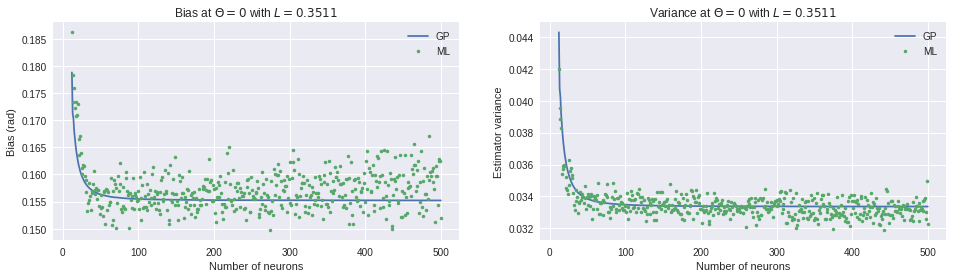

In [5]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501

n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 11

plt.subplot(121)
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_GP[skip_idx:], label='GP')
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_ML[skip_idx:], '.', label='ML')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')
plt.title('Bias at $\Theta=0$ with $L = 0.3511$')

plt.subplot(122)
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_GP[skip_idx:], label='GP')
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_ML[skip_idx:], '.', label='ML')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$ with $L = 0.3511$')

plt.rcParams['figure.figsize'] = (10, 5) 

It is apparent that the ML method gives bias values which are 'noisy' with respect to the (smooth) GP curve (**why?**).

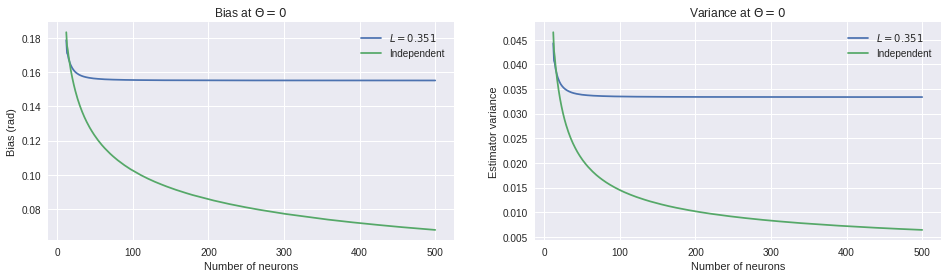

In [4]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501

n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 11

plt.subplot(121)
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_GP[skip_idx:], label='$L = 0.351$')
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_ind_GP[skip_idx:], label='Independent')
plt.legend()
plt.title('Bias at $\Theta=0$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

plt.subplot(122)
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_GP[skip_idx:], label='$L = 0.351$')
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_ind_GP[skip_idx:], label='Independent')
plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$')


plt.rcParams['figure.figsize'] = (10, 5) 

These plots clearly show the saturation of the bias and variance for increasing $N$ in the presence of correlated noise.

#### Experiment 3

We will now try to run the following models:
* $L = 0.08$ (increased bias for $N = 100$ but less than for $L = 0.35$)
* $L = 10$ (reduced bias for $N = 100$)
* $L = 23200$ (reduced bias for $N = 100$)


In [5]:
max_corr = 1.0
corr_length = 0.08

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_ML_1 = np.zeros(len(n_neurons_arr))
variances_neurons_corr_ML_1 = np.zeros(len(n_neurons_arr))

biases_neurons_corr_GP_1 = np.zeros(len(n_neurons_arr))
variances_neurons_corr_GP_1 = np.zeros(len(n_neurons_arr))

for i in range(len(n_neurons_arr)):
    cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length, n_neurons=n_neurons_arr[i])
    (biases_neurons_corr_ML_1[i], variances_neurons_corr_ML_1[i]) = get_ML_ests_stim_0_new(n_neurons_arr[i], cov_mtx)
    (biases_neurons_corr_GP_1[i], variances_neurons_corr_GP_1[i]) = get_GP_ests_stim_0_new(n_neurons_arr[i], cov_mtx)
    
dill.dump_session('session_state.pkl')

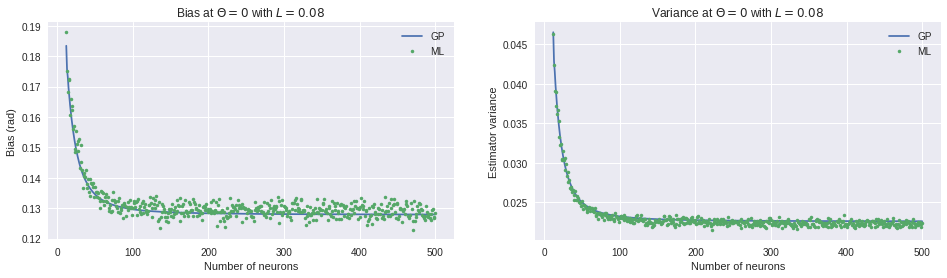

In [16]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 11

plt.subplot(121)
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_GP_1[skip_idx:], label='GP')
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_ML_1[skip_idx:], '.', label='ML')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')
plt.title('Bias at $\Theta=0$ with $L = 0.08$')

plt.subplot(122)
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_GP_1[skip_idx:], label='GP')
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_ML_1[skip_idx:], '.', label='ML')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$ with $L = 0.08$')

plt.rcParams['figure.figsize'] = (10, 5) 

One observation from the above plots is that the bias and variance for the ML approach with correlation length $L = 0.08$ fluctuates less around the GP curve compared with correlation length $L = 0.35$.

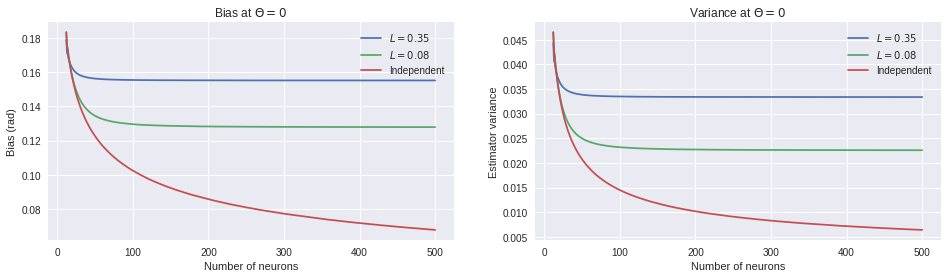

In [6]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 11

plt.subplot(121)
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_GP[skip_idx:], label='$L = 0.35$')
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_GP_1[skip_idx:], label='$L = 0.08$')
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_ind_GP[skip_idx:], label='Independent')

plt.legend()
plt.title('Bias at $\Theta=0$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

plt.subplot(122)
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_GP[skip_idx:], label='$L = 0.35$')
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_GP_1[skip_idx:], label='$L = 0.08$')
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_ind_GP[skip_idx:], label='Independent')
plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$')


plt.rcParams['figure.figsize'] = (10, 5) 

In [35]:
print 'Bias saturation value'
print 'L = 0.35 : {0:.3f}'.format(biases_neurons_corr_GP[-1])
print 'L = 0.08 : {0:.3f}'.format(biases_neurons_corr_GP_1[-1])

print ''
print 'Variance saturation value'
print 'L = 0.35 : {0:.3f}'.format(variances_neurons_corr_GP[-1])
print 'L = 0.08 : {0:.3f}'.format(variances_neurons_corr_GP_1[-1])

Bias saturation value
L = 0.35 : 0.155
L = 0.08 : 0.128

Variance saturation value
L = 0.35 : 0.033
L = 0.08 : 0.023


We see that the model with correlation length $L = 0.35$ saturates at a larger value of the bias (and variance) than the model with correlation length $L = 0.08$.

**Singular matrix error**

When setting $L > 4.4$, leads to error when inverting covariance matrix for some settings of population size.

The error indicates that the corresponding noise covariance matrices are singular (i.e. non-invertible) `LinAlgError: Singular matrix`

#### Experiment 4

We will vary L from [0.1, 4.4] in intervals of 0.1 for ML only (GP takes too long)

In [80]:
corr_length_arr = np.linspace(0.1, 4.4, 44)
corr_length_arr

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4])

In [91]:
max_corr = 1.0
corr_length_arr = np.linspace(0.1, 4.4, 44)
corr_length_arr = corr_length_arr[:10]

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_ML_2 = np.zeros((len(corr_length_arr), len(n_neurons_arr)))
variances_neurons_corr_ML_2 = np.zeros((len(corr_length_arr), len(n_neurons_arr)))

for i in range(len(corr_length_arr)):
    for j in range(len(n_neurons_arr)):
        cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length_arr[i], n_neurons=n_neurons_arr[j])
        (biases_neurons_corr_ML_2[i,j], variances_neurons_corr_ML_2[i,j]) = get_ML_ests_stim_0_new(n_neurons_arr[j], cov_mtx)

dill.dump_session('session_state.pkl')

In [92]:
max_corr = 1.0
corr_length_arr = np.linspace(0.1, 4.4, 44)
corr_length_arr = corr_length_arr[10:20]

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_ML_3 = np.zeros((len(corr_length_arr), len(n_neurons_arr)))
variances_neurons_corr_ML_3 = np.zeros((len(corr_length_arr), len(n_neurons_arr)))

for i in range(len(corr_length_arr)):
    for j in range(len(n_neurons_arr)):
        cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length_arr[i], n_neurons=n_neurons_arr[j])
        (biases_neurons_corr_ML_3[i,j], variances_neurons_corr_ML_3[i,j]) = get_ML_ests_stim_0_new(n_neurons_arr[j], cov_mtx)

dill.dump_session('session_state.pkl')

In [93]:
max_corr = 1.0
corr_length_arr = np.linspace(0.1, 4.4, 44)
corr_length_arr = corr_length_arr[20:30]

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_ML_4 = np.zeros((len(corr_length_arr), len(n_neurons_arr)))
variances_neurons_corr_ML_4 = np.zeros((len(corr_length_arr), len(n_neurons_arr)))

for i in range(len(corr_length_arr)):
    for j in range(len(n_neurons_arr)):
        cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length_arr[i], n_neurons=n_neurons_arr[j])
        (biases_neurons_corr_ML_4[i,j], variances_neurons_corr_ML_4[i,j]) = get_ML_ests_stim_0_new(n_neurons_arr[j], cov_mtx)

dill.dump_session('session_state.pkl')

In [94]:
max_corr = 1.0
corr_length_arr = np.linspace(0.1, 4.4, 44)
corr_length_arr = corr_length_arr[30:]

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_ML_5 = np.zeros((len(corr_length_arr), len(n_neurons_arr)))
variances_neurons_corr_ML_5 = np.zeros((len(corr_length_arr), len(n_neurons_arr)))

for i in range(len(corr_length_arr)):
    for j in range(len(n_neurons_arr)):
        cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length_arr[i], n_neurons=n_neurons_arr[j])
        (biases_neurons_corr_ML_5[i,j], variances_neurons_corr_ML_5[i,j]) = get_ML_ests_stim_0_new(n_neurons_arr[j], cov_mtx)

dill.dump_session('session_state.pkl')

In [17]:
biases_neurons_corr_ML_all = np.concatenate((biases_neurons_corr_ML_2, biases_neurons_corr_ML_3, biases_neurons_corr_ML_4, biases_neurons_corr_ML_5), axis=0)
variances_neurons_corr_ML_all = np.concatenate((variances_neurons_corr_ML_2, variances_neurons_corr_ML_3, variances_neurons_corr_ML_4, variances_neurons_corr_ML_5), axis=0)

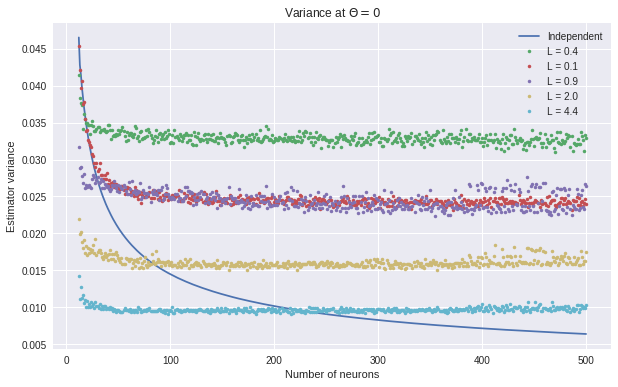

In [148]:
plt.rcParams['figure.figsize'] = (10, 6) 

corr_length_arr = np.linspace(0.1, 4.4, 44)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 11

plt.plot(n_neurons_arr[skip_idx:], variances_neurons_ind_GP[skip_idx:], label='Independent')

i = 3
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_ML_all[i,:][skip_idx:], '.', label='L = {0}'.format(corr_length_arr[i]))

i = 0
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_ML_all[i,:][skip_idx:], '.', label='L = {0}'.format(corr_length_arr[i]))

i = 8
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_ML_all[i,:][skip_idx:], '.', label='L = {0}'.format(corr_length_arr[i]))

i = 19
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_ML_all[i,:][skip_idx:], '.', label='L = {0}'.format(corr_length_arr[i]))

i = 43
plt.plot(n_neurons_arr[skip_idx:], variances_neurons_corr_ML_all[i,:][skip_idx:], '.', label='L = {0}'.format(corr_length_arr[i]))

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$')

plt.rcParams['figure.figsize'] = (10, 5) 

The value at which the variance saturates for increasing N rises for correlation lengths $L = 0.1 \to 0.4$.

It then decreases for increasing $L$.

It is observed that at $L = 0.9$, the variance saturation value approximately matches the value for $L=0.1$.

We know from previously that for $N = 100$, the value of the correlation length for which the bias is less than that of the independent model starts at $L = 2.85$.

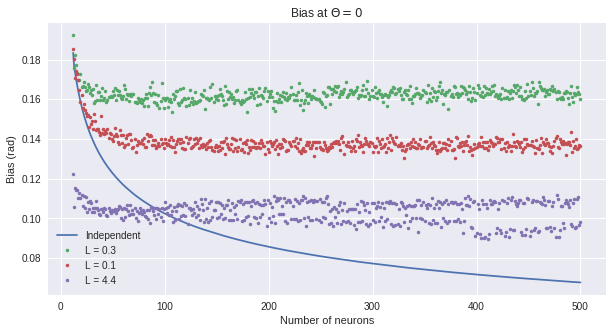

In [193]:
corr_length_arr = np.linspace(0.1, 4.4, 44)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 11

plt.plot(n_neurons_arr[skip_idx:], biases_neurons_ind_GP[skip_idx:], label='Independent')

i = 2
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_ML_all[i,:][skip_idx:], '.', label='L = {0}'.format(corr_length_arr[i]))

i = 0
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_ML_all[i,:][skip_idx:], '.', label='L = {0}'.format(corr_length_arr[i]))

i = 43
plt.plot(n_neurons_arr[skip_idx:], biases_neurons_corr_ML_all[i,:][skip_idx:], '.', label='L = {0}'.format(corr_length_arr[i]))

plt.legend()
plt.title('Bias at $\Theta=0$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

We observe similar behaviour for the bias.

**Unusual behaviour of bias**

However, the plotted points corresponding to the bias for a given population size appear to diverge (as shown above for $L = 4.4$).
This behaviour starts for correlation lengths $L \geq 0.4$.

**Experiment 5**

We run the GP framework for the following models with values of $L \in \{0.9, 2.0, 4.4\}$

In [7]:
max_corr = 1.0
corr_length = 0.9

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_GP_2_l09 = np.zeros(len(n_neurons_arr))
variances_neurons_corr_GP_2_l09 = np.zeros(len(n_neurons_arr))

for j in range(len(n_neurons_arr)):
    cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length, n_neurons=n_neurons_arr[j])
    (biases_neurons_corr_GP_2_l09[j], variances_neurons_corr_GP_2_l09[j]) = get_GP_ests_stim_0_new(n_neurons_arr[j], cov_mtx)
    print n_neurons_arr[j]
    
dill.dump_session('session_state1.pkl')

In [ ]:
# biases_neurons_corr_GP_2_l09
# biases_neurons_corr_GP_2_l2
# biases_neurons_corr_GP_2_l44

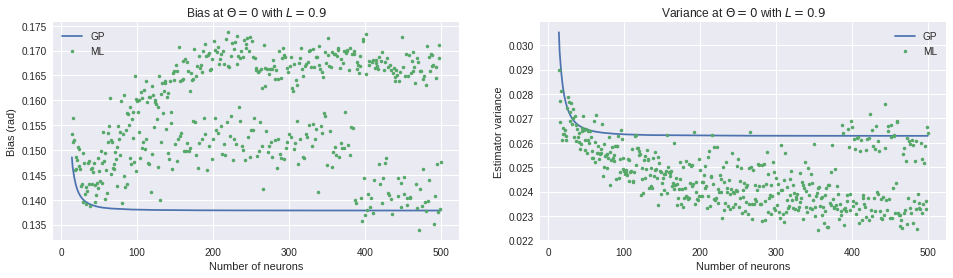

In [80]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

# L = 0.9 - Bias
plt.subplot(121)
start_idx = 13
end_idx = 501

plt.plot(n_neurons_arr[start_idx:end_idx], biases_neurons_corr_GP_2_l09[start_idx:end_idx], label='GP')
plt.plot(n_neurons_arr[start_idx:end_idx], biases_neurons_corr_ML_all[8, start_idx:end_idx], '.', label='ML')

plt.legend()
plt.title('Bias at $\Theta=0$ with $L = 0.9$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

# L = 0.9 - Variance
plt.subplot(122)
start_idx = 13
end_idx = 501

plt.plot(n_neurons_arr[start_idx:end_idx], variances_neurons_corr_GP_2_l09[start_idx:end_idx], label='GP')
plt.plot(n_neurons_arr[start_idx:end_idx], variances_neurons_corr_ML_all[8, start_idx:end_idx], '.', label='ML')

plt.legend()
plt.title('Variance at $\Theta=0$ with $L = 0.9$')
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')

plt.rcParams['figure.figsize'] = (10, 5)

There is clear divergence of the ML points compared with the GP points.

At $N=100$, the value of the bias for the GP curve (0.138) appears the most correct i.e. it matches previous values observed near $L = 0.9$.

It is strange that the ML estimates are off, especially the one for $N=100$.

One possible explanation could be in the way the preferred orientations are distributed in the modified `get_ML_ests_stim_0_new()` function in which the upper bound ($+\pi$) is included.

The following demonstrates the issue for $N = 100$:

In [115]:
cov_mtx = construct_cov_matrix(corr_length=0.9)

get_ML_ests_stim_0(cov_mtx)

(0.13501936906598214, 0.026263723145927134)

In [127]:
cov_mtx = construct_cov_matrix_new(corr_length=0.9)

get_ML_ests_stim_0_new(100, cov_mtx)

(0.15962432272889743, 0.025447431695049927)

In [101]:
cov_mtx = construct_cov_matrix(corr_length=0.9)

get_GP_ests_stim_0(cov_mtx)

(0.13798346676807105, 0.026342855851305715)

In [112]:
cov_mtx = construct_cov_matrix_new(corr_length=0.9)

get_GP_ests_stim_0_new(100, cov_mtx)

(0.13798712149253251, 0.026344469428498097)

Strangely, the difference in the arrangement of preferred orientations does not affect the GP approach but affects the ML estimate.

I changed the preferred orientation arrangement back to the original layout in the code to see what happens.

In [155]:
max_corr = 1.0
corr_length = 0.9

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_ML_l09 = np.zeros(len(n_neurons_arr))
variances_neurons_corr_ML_l09 = np.zeros(len(n_neurons_arr))

for j in range(len(n_neurons_arr)):
    cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length, n_neurons=n_neurons_arr[j])
    (biases_neurons_corr_ML_l09[j], variances_neurons_corr_ML_l09[j]) = get_ML_ests_stim_0_new(n_neurons_arr[j], cov_mtx)
    print n_neurons_arr[j]

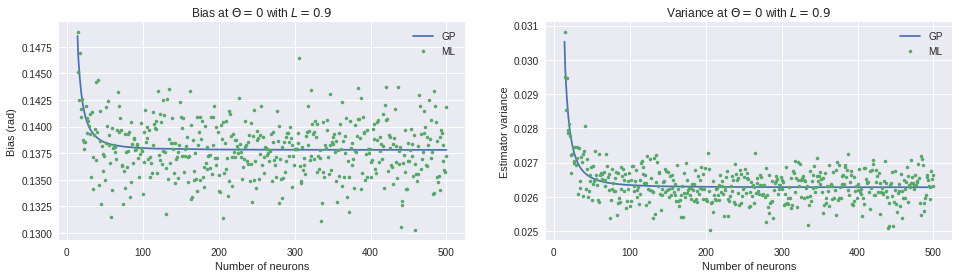

In [156]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

# L = 0.9 - Bias
plt.subplot(121)
start_idx = 13
end_idx = 501

plt.plot(n_neurons_arr[start_idx:end_idx], biases_neurons_corr_GP_2_l09[start_idx:end_idx], label='GP')
plt.plot(n_neurons_arr[start_idx:end_idx], biases_neurons_corr_ML_l09[start_idx:end_idx], '.', label='ML')

plt.legend()
plt.title('Bias at $\Theta=0$ with $L = 0.9$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

# L = 0.9 - Variance
plt.subplot(122)
start_idx = 13
end_idx = 501

plt.plot(n_neurons_arr[start_idx:end_idx], variances_neurons_corr_GP_2_l09[start_idx:end_idx], label='GP')
plt.plot(n_neurons_arr[start_idx:end_idx], variances_neurons_corr_ML_l09[start_idx:end_idx], '.', label='ML')

plt.legend()
plt.title('Variance at $\Theta=0$ with $L = 0.9$')
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')

plt.rcParams['figure.figsize'] = (10, 5)

Now, we observe something more reasonable.

The ML estimates generally follow the GP curve though the points are quite noisy.

In [159]:
max_corr = 1.0
corr_length = 2.0

n_neurons_upper = 301
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_ML_l20 = np.zeros(len(n_neurons_arr))
variances_neurons_corr_ML_l20 = np.zeros(len(n_neurons_arr))

for j in range(len(n_neurons_arr)):
    cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length, n_neurons=n_neurons_arr[j])
    (biases_neurons_corr_ML_l20[j], variances_neurons_corr_ML_l20[j]) = get_ML_ests_stim_0_new(n_neurons_arr[j], cov_mtx)
    print n_neurons_arr[j]

In [162]:
max_corr = 1.0
corr_length = 4.4

n_neurons_upper = 301
n_neurons_arr = np.arange(1, n_neurons_upper)

biases_neurons_corr_ML_l44 = np.zeros(len(n_neurons_arr))
variances_neurons_corr_ML_l44 = np.zeros(len(n_neurons_arr))

for j in range(len(n_neurons_arr)):
    cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length, n_neurons=n_neurons_arr[j])
    (biases_neurons_corr_ML_l44[j], variances_neurons_corr_ML_l44[j]) = get_ML_ests_stim_0_new(n_neurons_arr[j], cov_mtx)
    print n_neurons_arr[j]

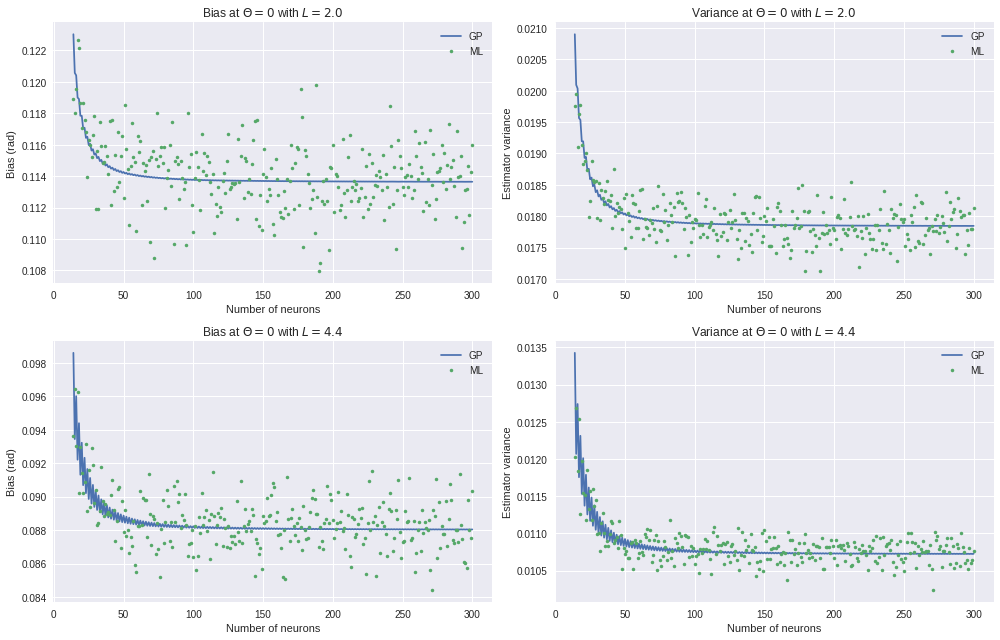

In [163]:
plt.rcParams['figure.figsize'] = (14, 9)

n_neurons_upper = 301
n_neurons_arr = np.arange(1, n_neurons_upper)

# L = 2.0 - Bias
plt.subplot(221)
start_idx = 13
end_idx = 300

plt.plot(n_neurons_arr[start_idx:], biases_neurons_corr_GP_2_l2[start_idx:end_idx], label='GP')
plt.plot(n_neurons_arr[start_idx:], biases_neurons_corr_ML_l20[start_idx:], '.', label='ML')

plt.legend()
plt.title('Bias at $\Theta=0$ with $L = 2.0$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

# L = 2.0 - Variance
plt.subplot(222)
start_idx = 13
end_idx = 300

plt.plot(n_neurons_arr[start_idx:], variances_neurons_corr_GP_2_l2[start_idx:end_idx], label='GP')
plt.plot(n_neurons_arr[start_idx:], variances_neurons_corr_ML_l20[start_idx:], '.', label='ML')

plt.legend()
plt.title('Variance at $\Theta=0$ with $L = 2.0$')
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')

# L = 4.4 - Bias
plt.subplot(223)
start_idx = 13
end_idx = 300

plt.plot(n_neurons_arr[start_idx:], biases_neurons_corr_GP_2_l44[start_idx:end_idx], label='GP')
plt.plot(n_neurons_arr[start_idx:], biases_neurons_corr_ML_l44[start_idx:], '.', label='ML')

plt.legend()
plt.title('Bias at $\Theta=0$ with $L = 4.4$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

# L = 4.4 - Variance
plt.subplot(224)
start_idx = 13
end_idx = 300

plt.plot(n_neurons_arr[start_idx:], variances_neurons_corr_GP_2_l44[start_idx:end_idx], label='GP')
plt.plot(n_neurons_arr[start_idx:], variances_neurons_corr_ML_l44[start_idx:], '.', label='ML')

plt.legend()
plt.title('Variance at $\Theta=0$ with $L = 4.4$')
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

We observe an oscillation in the GP curve for $L = 2$ and $L = 4.4$ (above) which appears for both the bias and variance plots.

The oscillation appears more significant in the $L = 4.4$ plot.

Perhaps try again with the reverted preferred orientation arrangement structure? This time with respect to the GP code.

In [26]:
n_neurons_arr = np.arange(14, 50)

max_corr = 1.0
corr_length = 4.4

biases_neurons_corr_GP_2_l44_check = np.zeros(len(n_neurons_arr))
variances_neurons_corr_GP_2_l44_check = np.zeros(len(n_neurons_arr))

for j in range(len(n_neurons_arr)):
    cov_mtx = construct_cov_matrix_new(max_corr=max_corr, corr_length=corr_length, n_neurons=n_neurons_arr[j])
    (biases_neurons_corr_GP_2_l44_check[j], variances_neurons_corr_GP_2_l44_check[j]) = get_GP_ests_stim_0_new(n_neurons_arr[j], cov_mtx)
    print n_neurons_arr[j]

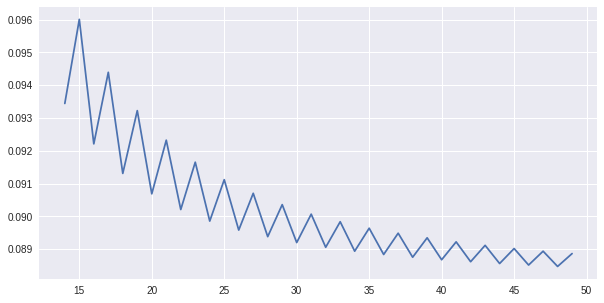

In [10]:
n_neurons_arr = np.arange(14, 50)

plt.plot(n_neurons_arr, biases_neurons_corr_GP_2_l44_check)

We observe no change. Oscillations not caused by preferred orientation structure.

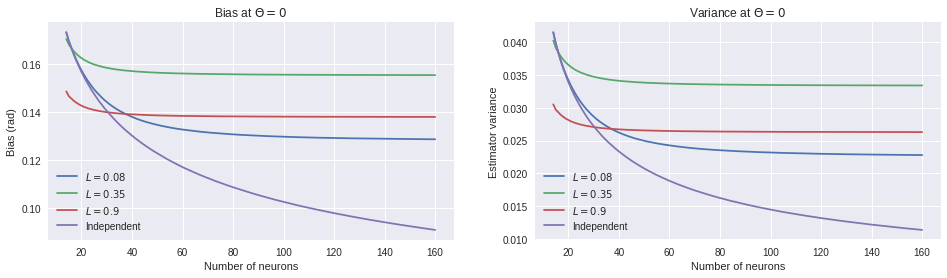

In [198]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 13
end_idx = 160

plt.subplot(121)
plt.plot(n_neurons_arr[skip_idx:end_idx], biases_neurons_corr_GP_1[skip_idx:end_idx], label='$L = 0.08$')
plt.plot(n_neurons_arr[skip_idx:end_idx], biases_neurons_corr_GP[skip_idx:end_idx], label='$L = 0.35$')
plt.plot(n_neurons_arr[skip_idx:end_idx], biases_neurons_corr_GP_2_l09[skip_idx:end_idx], label='$L = 0.9$')
plt.plot(n_neurons_arr[skip_idx:end_idx], biases_neurons_ind_GP[skip_idx:end_idx], label='Independent')

plt.legend()
plt.title('Bias at $\Theta=0$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

plt.subplot(122)
plt.plot(n_neurons_arr[skip_idx:end_idx], variances_neurons_corr_GP_1[skip_idx:end_idx], label='$L = 0.08$')
plt.plot(n_neurons_arr[skip_idx:end_idx], variances_neurons_corr_GP[skip_idx:end_idx], label='$L = 0.35$')
plt.plot(n_neurons_arr[skip_idx:end_idx], variances_neurons_corr_GP_2_l09[skip_idx:end_idx], label='$L = 0.9$')
plt.plot(n_neurons_arr[skip_idx:end_idx], variances_neurons_ind_GP[skip_idx:end_idx], label='Independent')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$')


plt.rcParams['figure.figsize'] = (10, 5) 

We observe that the value at which the bias/variance saturates (for increasing N) increases when the correlation length is increased from 0.08 to 0.35.

However, as the correlation length is further increased to 0.9, the saturation value decreases.

We also observe that the curve appears sharper for small N as we increase the correlation length.

Thus, as $L$ increases, it appears that the minimum number of neurons required to achieve the lowest possible bias/variance for a given correlation length decreases.

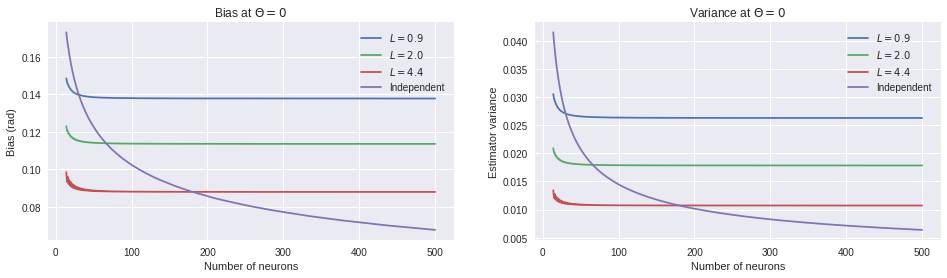

In [5]:
plt.rcParams['figure.figsize'] = (16, 4)

n_neurons_upper = 501
n_neurons_arr = np.arange(1, n_neurons_upper)

skip_idx = 13
end_idx = 501

plt.subplot(121)
plt.plot(n_neurons_arr[skip_idx:end_idx], biases_neurons_corr_GP_2_l09[skip_idx:end_idx], label='$L = 0.9$')
plt.plot(n_neurons_arr[skip_idx:end_idx], biases_neurons_corr_GP_2_l2[skip_idx:end_idx], label='$L = 2.0$')
plt.plot(n_neurons_arr[skip_idx:end_idx], biases_neurons_corr_GP_2_l44[skip_idx:end_idx], label='$L = 4.4$')
plt.plot(n_neurons_arr[skip_idx:end_idx], biases_neurons_ind_GP[skip_idx:end_idx], label='Independent')

plt.legend()
plt.title('Bias at $\Theta=0$')
plt.xlabel('Number of neurons')
plt.ylabel('Bias (rad)')

plt.subplot(122)
plt.plot(n_neurons_arr[skip_idx:end_idx], variances_neurons_corr_GP_2_l09[skip_idx:end_idx], label='$L = 0.9$')
plt.plot(n_neurons_arr[skip_idx:end_idx], variances_neurons_corr_GP_2_l2[skip_idx:end_idx], label='$L = 2.0$')
plt.plot(n_neurons_arr[skip_idx:end_idx], variances_neurons_corr_GP_2_l44[skip_idx:end_idx], label='$L = 4.4$')
plt.plot(n_neurons_arr[skip_idx:end_idx], variances_neurons_ind_GP[skip_idx:end_idx], label='Independent')

plt.legend()
plt.xlabel('Number of neurons')
plt.ylabel('Estimator variance')
plt.title('Variance at $\Theta=0$')


plt.rcParams['figure.figsize'] = (10, 5) 

If we further increase the correlation length, the value at which the bias/variance saturates for increasing N reduces further (as expected).

The following is the minimum number of neurons required to achieve the lowest possible bias for a given correlation length:

L | Min_N

0.08 | 167

0.35 |  95 

0.9  |  50

2.0  |  42

4.4  |  66 

This agrees with the observations above.

It is interesting that minimum N increased slightly as the correlation length increased from 2.0 to 4.4